# **Machine Learning Applications: Final Project**

---
## Group Members:

- **100496616** Iqbal Chaudhry Mora
- **100495777** César Ramírez Chaves
- **100496619** Ignacio Torrego Diez
---

# **Analysis of Spain's Political Landscape with Reddit**

## **1. Description**

## Index:

1. Introduction
2. Data set creation
3. Text Vectorization
4. Classification Task
5. Inference over Reddit Dataset
6. Conclusions

## **1. Introduction**



![alt text](images/AML.jpg "Title")

For this project, we conducted an analysis of the public perception of Spanish politics. This was made possible with a dataset we scraped from the subreddit r/SpainPolitics (https://www.reddit.com/r/SpainPolitics/), we chose this subreddit as it is a big community that was created in 2019 so it captures most of the last 6 years in politics which have been really intersing from COVID-19 to recent events like the war in Ukraine and how this affected our country and other events like Trumps tariffs on Spain, also this comunity has active moderation and guidelines that should make it a great source of "unbiased" information and opinions. Our primary goal was analyze shifts in general public sentiment over different time periods.

To make possible the classification of the collected Reddit text, we trained a multi-label classifier designed to output one of six distinct emotion categories: Sadness, Joy, Love, Anger, Surprise, and Fear. The training data for this classifier was obtained from the pre-labelled dair-ai/emotion dataset on Hugging Face (https://huggingface.co/datasets/dair-ai/emotion/). 

Finally the chosen architecture for our classifier was an LSTM neural network augmented with an attention mechanism. We chose this approach as the attention mechanism represents a State-of-the-Art (SOTA) technique in natural language processing, which we thought would significantly enhance the model's ability to focus on the most relevant parts of the text for accurate emotion classification in this context.




Disclaimer:

As politics usually is a sensitive topic we are trying to be as objective as as possible. The authors of this work have made every effort to ensure neutrality during this analysis from the beggining by recopilating data until the end with the interpretation of the results. No personal or political beliefs are expressed or endorsed in this report. Any opinions inferred from the results are a reflection of the analyzed content and not of the team conducting the analysis.

## **2. Data set creation and Text Preprocessing** 

As mentioned before we obtained 2 datasets one from Hugging Face and the other one from Reddit using the Reddit's API tool for python: praw (https://praw.readthedocs.io/en/stable/)

First we import all the necessary libraries for the project

In [2]:
#!python -m spacy download en_core_web_md
#!python -m spacy download es_core_news_md
#!pip install sacremoses
#!pip install praw
#!pip install transformers
#!pip install huggingface_hub
#!pip install termcolor
#!pip install wordcloud

[]

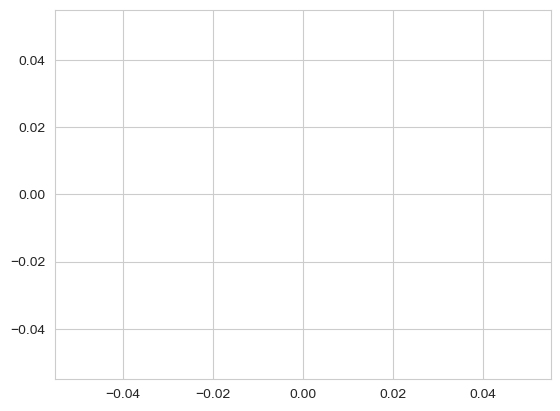

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.plot()

In [4]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
import praw, pandas as pd
import numpy as np
import spacy
import re
from transformers import pipeline
import torch
import ast
from transformers import MarianMTModel, MarianTokenizer
from concurrent.futures import ThreadPoolExecutor
from gensim.corpora import Dictionary
from wordcloud import WordCloud
from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from collections import defaultdict
from wordcloud import WordCloud
from gensim.models import TfidfModel
from collections import Counter
import seaborn as sns
from termcolor import colored
import joblib
import gc
from torch import nn
from torch import optim
from sklearn import metrics
from sklearn.preprocessing import label_binarize
import torch
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from gensim.matutils import corpus2dense, corpus2csc
import textwrap  

### Data Collection

The following commented code shows the process to collect all the available posts and post comments from the subreddit, this code should run if you add the keys for the Reddit API, now they are not available mostly for privacy reasons

<pre>
subreddits = ["SpainPolitics"]

CLIENT_ID = "CLIENT_ID"
CLIENT_SECRET = "CLIENT_SECRET"

reddit = praw.Reddit(
    client_id = CLIENT_ID,
    client_secret = CLIENT_SECRET,
    username = "username",
    password = "password",
    user_agent="FinalAML"
)

records = []

for sr in subreddits:
    for post in reddit.subreddit(sr).hot(limit=10000):
        # Add the post itself
        records.append({
            "type": "post",
            "subreddit": sr,
            "post_id": post.id,
            "comment_id": None,
            "parent_id": None,
            "created_utc": post.created_utc,
            "score": post.score,
            "text": post.title + "\n" + post.selftext
        })

        # Now add comments for the post
        post.comments.replace_more(limit=0)
        for comment in post.comments.list():
            records.append({
                "type": "comment",
                "subreddit": sr,
                "post_id": post.id,
                "comment_id": comment.id,
                "parent_id": comment.parent_id,
                "created_utc": comment.created_utc,
                "score": comment.score,
                "text": comment.body
            })

df = pd.DataFrame(records)

df["lengths"] = df.text.apply(lambda x: len(x.split(" ")))
df = df[df.lengths <= 250]
df = df[df.lengths > 5]
</pre>

### Translate Text

Once we have obtained the raw text we encounter a major problem and that being that most of the text we have scrapped is in spanosh and the text available in the second dataset that is going to be used to train the classifier is in english so in order to obtain better and more coherent result we translated each one of the 17k documents

To do that we loaded a Transformer model from Hugging Face, the Helsinki-NLP/opus-mt-es-en (https://huggingface.co/Helsinki-NLP/opus-mt-es-en) we run the model locally and translated all the text,  we decided to go with this option as transformers are State-Of-The-Art models and we wanted to obtain the best results for our project ensuring that common expression are not lost in the process of translating the text

<pre>
# Load model and tokenizer
model_name = "Helsinki-NLP/opus-mt-es-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


all_texts = df["text"].to_list()

batch_size = 2  
results = []

# Function to handle batch translation
def translate_batch(batch_texts):
    
    encoded = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        translated = model.generate(**encoded, max_length=256)

    return tokenizer.batch_decode(translated, skip_special_tokens=True)

for i in range(0, len(all_texts), batch_size):
    batch_texts = all_texts[i:i + batch_size]

    translated_batch = translate_batch(batch_texts)
    results.extend(translated_batch)
    
    print(f"Translated batch {i//batch_size + 1}/{(len(all_texts) + batch_size - 1)//batch_size}")

print(f"Total translations completed: {len(results)}")

df["translated_text"] = results

df.to_csv("rSpainPolitics.csv", index= False)
</pre>

The final structure of the scrapped text from reddit looks like this:

In [6]:
df = pd.read_csv("data/rSpainPolitics.csv")

In [7]:
df[df.type == "post"]

type      subreddit  post_id comment_id parent_id   created_utc  score  \
0      post  SpainPolitics  1k0oan5        NaN       NaN  1.744820e+09     12   
2      post  SpainPolitics  1k0ffny        NaN       NaN  1.744792e+09     15   
6      post  SpainPolitics  1jzskt6        NaN       NaN  1.744726e+09     58   
28     post  SpainPolitics  1jzqnq2        NaN       NaN  1.744720e+09     40   
42     post  SpainPolitics  1jzt3co        NaN       NaN  1.744727e+09      5   
...     ...            ...      ...        ...       ...           ...    ...   
12702  post  SpainPolitics  1ftkwjp        NaN       NaN  1.727779e+09     32   
12715  post  SpainPolitics  1ftkmaf        NaN       NaN  1.727778e+09     27   
12723  post  SpainPolitics  1ftkssl        NaN       NaN  1.727778e+09     23   
12732  post  SpainPolitics  1ftjuv5        NaN       NaN  1.727774e+09      9   
12742  post  SpainPolitics  1ft4f0w        NaN       NaN  1.727725e+09     42   

                                                    text  \
0      Informe GRECO sobre España: Corruption prevent...   
2      El juez Peinado multa al abogado de Begoña Góm...   
6      Adiós a los 1.200 comedores escolares sin pesc...   
28     ‘Caso Begoña Gómez’: cero indicios y cinco imp...   
42     Recomendaciones para periodistas políticos\nHo...   
...                                                  ...   
12702  Los colegios concertados cobran cuotas cada ve...   
12715  La Junta de Andalucía fraccionó miles de contr...   
12723  Elche apoya reparar a Miguel Hernández con la ...   
12732  RTVE suspende el examen de oposición para peri...   
12742  El banco húngaro señalado por financiar a Vox ...   

                                                  tokens  lengths  \
0      ['informe', 'greco', 'españa', 'corruption', '...       14   
2      ['juez', 'peinado', 'multa', 'abogado', 'begoñ...       28   
6      ['adiós', 'comedor', 'escolar', 'pescado', 'bo...       22   
28     ['caso', 'begoña', 'gómez', 'cero', 'indicio',...       13   
42     ['recomendación', 'periodista', 'político', 'h...       80   
...                                                  ...      ...   
12702  ['colegio', 'concertado', 'cobrar', 'cuota', '...       14   
12715  ['junta', 'andalucía', 'fraccionar', 'mil', 'c...       22   
12723  ['elche', 'apoyar', 'reparar', 'miguel', 'hern...       18   
12732  ['rtve', 'suspender', 'examen', 'oposición', '...       11   
12742  ['banco', 'húngaro', 'señalado', 'financiar', ...       16   

                                         translated_text  
0      GRECO report on Spain: Corruption prevention i...  
2      Judge Peinado fined Begoña Gomez's lawyer €5,0...  
6      Farewell to 1,200 unfished school canteens and...  
28     ‘Case Begoña Gómez’: zero indicia and five acc...  
42     Recommendations for political journalists Hell...  
...                                                  ...  
12702  Concerted schools charge increasingly high fee...  
12715  The Junta de Andalucía split thousands of cont...  
12723  Elche supports repairing Miguel Hernández with...  
12732  RTVE suspends the opposition examination for j...  
12742  The Hungarian bank designated to finance Vox h...  

[891 rows x 11 columns]

Now we will apply the cleaning and proper tokenizations techniques for the text in spanish we will use the SpaCy model "es_core_news_md"

In [8]:
nlp = spacy.load("es_core_news_md", disable=["parser","ner"])

In [9]:
def preprocess(text):
    # Delete expressions
    text = re.sub(r"http\S+|@\S+","", text)
    # Turn into lowecases
    text = text.lower()
    # SpaCy preprocessing
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and not token.is_punct
        and token.is_alpha
    ]
    return tokens

df["tokens"] = df["text"].apply(preprocess)
df["lengths"] = df.tokens.apply(lambda x: len(x))

The following lines apply the same preprocessing techniques we used for the text in spanish to its translated counterpart and we will also make the final structure for the Reddit Dataset

In [10]:
nlp = spacy.load("en_core_web_md", disable=["parser","ner"])
df["tokens_english"] = df["translated_text"].apply(preprocess)
df["english_lengths"] = df.tokens_english.apply(lambda x: len(x))

In [11]:
redditData = df[["created_utc","text","tokens","lengths","translated_text","tokens_english","english_lengths"]]

In [12]:
redditData= redditData[redditData.english_lengths >= 5]

In [13]:
redditData

created_utc                                               text  \
0      1.744820e+09  Informe GRECO sobre España: Corruption prevent...   
1      1.744841e+09  >that judges are to be elected by their peers ...   
2      1.744792e+09  El juez Peinado multa al abogado de Begoña Góm...   
3      1.744806e+09  Este hombre necesita una de casito de vez en c...   
4      1.744812e+09  Multa con 5000 al abogado de Begoña porque al ...   
...             ...                                                ...   
12746  1.727784e+09  Sorpresa el paniaguado de Esperanza Aguirre ah...   
12747  1.727775e+09  La contrapartida, ahora  diáfana, fue el que V...   
12748  1.727790e+09  >La Ley de financiación de partidos prohíbe cu...   
12749  1.727730e+09  Nada. No les pasará nada. Aunque la ley esté a...   
12751  1.727792e+09  Lo bueno que tenía Podemos era su independenci...   

                                                  tokens  lengths  \
0      [informe, greco, españa, corruption, preventio...       14   
1      [that, judg, are, to, be, elected, by, their, ...       54   
2      [juez, peinado, multa, abogado, begoña, gómez,...       12   
3      [hombre, necesitar, casito, lugar, dejar, juez...        7   
4      [multa, abogado, begoña, presentar, alegación,...       68   
...                                                  ...      ...   
12746  [sorpresa, paniaguado, esperanza, aguirre, orr...        7   
12747  [contrapartida, diáfán, vox, abandonar, grupo,...       43   
12748  [ley, financiación, partido, prohíbir, financi...       75   
12749  [pasar, ley, estar, suceder, resto, incumplir,...       18   
12751  [independencia, frente, banca, convertir, dian...       11   

                                         translated_text  \
0      GRECO report on Spain: Corruption prevention i...   
1      >that judges are to be elected by their peer (...   
2      Judge Peinado fined Begoña Gomez's lawyer €5,0...   
3      This man needs a little house from time to tim...   
4      A fine of 5000 for Begoña's lawyer because by ...   
...                                                  ...   
12746  Surprise Esperanza Aguirre's paniaguado now Or...   
12747  The counterpart, now open, was that Vox left t...   
12748  >The Law on the Financing of Parties prohibits...   
12749  Nothing. Nothing will happen to them. Even if ...   
12751  The good thing about Podemos was his independe...   

                                          tokens_english  english_lengths  
0      [greco, report, spain, corruption, prevention,...               10  
1      [judge, elect, peer, follow, method, guarantee...               44  
2      [judge, peinado, fine, begoña, gomez, lawyer, ...               12  
3      [man, need, little, house, time, time, bad, pl...               11  
4      [fine, begoña, lawyer, present, argument, call...               73  
...                                                  ...              ...  
12746  [surprise, esperanza, aguirre, paniaguado, orb...                7  
12747  [counterpart, open, vox, leave, group, europea...               42  
12748  [law, financing, party, prohibit, financing, g...               74  
12749  [happen, law, happen, like, rest, fail, happen...               20  
12751  [good, thing, podemos, independence, banking, ...               13  

[10882 rows x 7 columns]

In [117]:
redditData.to_pickle('redditData.pkl')

In [10]:
redditData = pd.read_pickle('data/redditData.pkl')

Lets have a look to one of the posts

In [15]:
print("================================== Text in Spanish ==================================")
print(colored(f"{redditData.loc[12747,"text"]}", ))

print("\n================================== Tokens in Spanish ==================================")
print(colored(f"{redditData.loc[12747,"tokens"]}", color = "blue"))

print("\n================================== Text in English ==================================")
print(colored(f"{redditData.loc[12747,"translated_text"]}", ))

print("\n================================== Tokens in English ==================================")
print(colored(f"{redditData.loc[12747,"tokens_english"]}", color = "green"))

================================== Text in Spanish ==================================
La contrapartida, ahora  diáfana, fue el que Vox abandonase  el grupo de los Conservadores y Reformistas Europeos (ECR), para pasarse al grupo Patriotas por Europa promovido por Orbán y con sus votos auparla como la 3 formación por importancia en al eurocamara.

No estaría de más señalar, como background, que la situación financiera de vox era mala; aun tiene que recibir la subvención a los partidos tras las generales -quizás por problemas con el Tribunal de Cuentas?- y por razones, digamos desconocidas, los bancos de aquí les cerraron el grifo, con lo que se les 'obligó' a buscar otros canales financieros.

================================== Tokens in Spanish ==================================
['contrapartida', 'diáfán', 'vox', 'abandonar', 'grupo', 'conservador', 'reformista', 'europeo', 'ecr', 'pasar él', 'grupo', 'patriota', 'europa', 'promovido', 'orbán', 'voto', 'aupar él', 'formación', 'importa

### Dataset for Training

As we have stated before we use a pre-labelled dataset that we will use later on for the training of our models. 
This dataset has the following structure:

A splitted (20k rows) and unsplitted (144k rows) versions,  for our project we ended up using the splitted versions as our machines could not handle the training process with a bigger dataset in a reasonable amount of time.

This dataset is divided in 3 parts

* Train: 16k rows 
* Validation: 2k rows
* Test: 2k rows

Also one of the main reasons why we chose this dataset is its diverese range of emotions as it can capture more than the usual positive/negative sentiment analysis datasets available.

These are the emotions in the dataset and its numerical values:

- 0: sadness
- 1: joy	
- 2: love
- 3: anger
- 4: fear
- 5: surprise

In [13]:
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
trainDF = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
validationDF = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
testDF = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

In [14]:
lenTrain = len(trainDF)
lenValidation = len(validationDF)
lenTest = len(testDF)

In [71]:
fullDF = pd.concat([trainDF,validationDF,testDF], ignore_index=True)

In [107]:
fullDF["tokens"] = fullDF["text"].apply(preprocess)

In [108]:
fullDF["lengths"] = fullDF.tokens.apply(lambda x: len(x))

In [111]:
fullDF.to_pickle('fullTraining.pkl')

In [9]:
fullDF = pd.read_pickle("data/fullTraining.pkl")

We save the lengths of each of the sets for later as now we want to make a full dataset that will be used to obtain both the final corpus and vocabulary for the text representations

In the following line we can see the final structure of the labeled dataset with and the tokens for each sentence after the same preprocessing we applied for the Reddit dataset

In [113]:
fullDF

text  label  \
0                                i didnt feel humiliated      0   
1      i can go from feeling so hopeless to so damned...      0   
2       im grabbing a minute to post i feel greedy wrong      3   
3      i am ever feeling nostalgic about the fireplac...      2   
4                                   i am feeling grouchy      3   
...                                                  ...    ...   
19995  i just keep feeling like someone is being unki...      3   
19996  im feeling a little cranky negative after this...      3   
19997  i feel that i am useful to my people and that ...      1   
19998  im feeling more comfortable with derby i feel ...      1   
19999  i feel all weird when i have to meet w people ...      4   

                                                  tokens  lengths  
0                                 [not, feel, humiliate]        3  
1         [feel, hopeless, damned, hopeful, care, awake]        6  
2           [m, grab, minute, post, feel, greedy, wrong]        7  
3           [feel, nostalgic, fireplace, know, property]        5  
4                                        [feel, grouchy]        2  
...                                                  ...      ...  
19995  [feel, like, unkind, wrong, think, people, close]        7  
19996  [m, feel, little, cranky, negative, doctor, ap...        7  
19997  [feel, useful, people, give, great, feeling, a...        7  
19998  [m, feel, comfortable, derby, feel, start, ste...        8  
19999  [feel, weird, meet, w, people, text, like, not...       12  

[20000 rows x 4 columns]

Lets have a look to some of the examples

In [90]:
# Sadness 

print("\n================================== Example of Sadness ==================================")
print(colored(f"{fullDF["text"][fullDF["label"] == 0].iloc[15]}", ))

print("================================== Tokens of Sadness ==================================")
print(colored(f"{fullDF["tokens"][fullDF["label"] == 0].iloc[15]}", color = "blue"))

# Joy 

print("\n\n\n================================== Example of Joy ==================================")
print(colored(f"{fullDF["text"][fullDF["label"] == 1].iloc[15]}", ))

print("================================== Tokens of Joy ==================================")
print(colored(f"{fullDF["tokens"][fullDF["label"] == 1].iloc[15]}", color = "yellow"))

# love 

print("\n\n\n================================== Example of Love ==================================")
print(colored(f"{fullDF["text"][fullDF["label"] == 2].iloc[85]}", ))

print("================================== Tokens of Love ==================================")
print(colored(f"{fullDF["tokens"][fullDF["label"] == 2].iloc[85]}", color = "magenta"))

# Anger 

print("\n\n\n================================== Example of Anger ==================================")
print(colored(f"{fullDF["text"][fullDF["label"] == 3].iloc[15]}", ))

print("================================== Tokens of Anger ==================================")
print(colored(f"{fullDF["tokens"][fullDF["label"] == 3].iloc[15]}", color = "red"))

# fear 

print("\n\n\n================================== Example of Fear ==================================")
print(colored(f"{fullDF["text"][fullDF["label"] == 4].iloc[15]}", ))

print("================================== Tokens of Fear ==================================")
print(colored(f"{fullDF["tokens"][fullDF["label"] == 4].iloc[15]}", color = "grey"))

# surprise 

print("\n\n\n================================== Example of Surprise ==================================")
print(colored(f"{fullDF["text"][fullDF["label"] == 5].iloc[15]}", ))

print("================================== Tokens of Surprise ==================================")
print(colored(f"{fullDF["tokens"][fullDF["label"] == 5].iloc[15]}", color = "green"))


================================== Example of Sadness ==================================
i hate living under my dads roof because it gives him an excuse to be an asshole to me because hes providing for me to live here i think he feels that he needs to make me feel as unwelcome as possible so ill leave
================================== Tokens of Sadness ==================================
['hate', 'live', 'dad', 'roof', 'give', 'excuse', 'asshole', 's', 'provide', 'live', 'think', 'feel', 'need', 'feel', 'unwelcome', 'possible', 'ill', 'leave']



================================== Example of Joy ==================================
ive worn it once on its own with a little concealer and for the days im feeling brave but dont want to be pale then its perfect
================================== Tokens of Joy ==================================
['ve', 'wear', 'little', 'concealer', 'day', 'm', 'feel', 'brave', 'not', 'want', 'pale', 'perfect']



================================== Example of

## **3. Text Vectorization**

The way we structure this part is the following:

- Classical BoW and TF-IDF representation.
- Word2vec and  FastText based representation that give us word embeddings.
- Extraction of themes and vector representation of the Reddit documents using the LDA algorithm.

Each of the mentioned sections are divided in two subsections, the first being the computation of the representation and the second one its visualization 

As we want to train a model with the labelled dataset to then predict the labels of the unlabelled one we should make a dictionary that uses all of the words present in both datasets.

Now lets start with the BoW representation of our combined corpus

In [23]:
corpus = fullDF["tokens"].to_list() + redditData["tokens_english"].to_list()

In [24]:
print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))

Number of documents in corpus: 30882


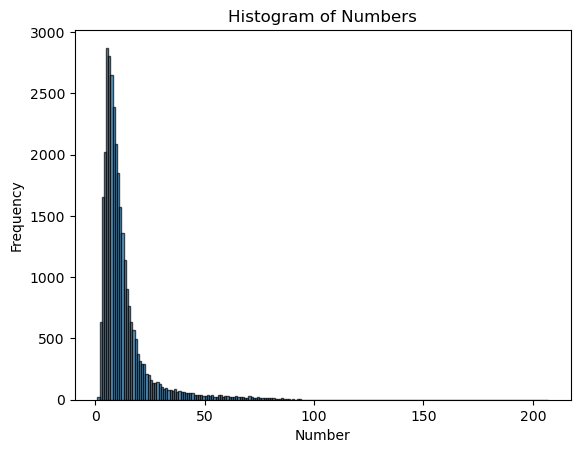

In [127]:
counts = [len(x) for x in corpus]
avg_tokens = np.mean(counts)

plt.hist(counts, bins=range(min(counts), max(counts) + 2), edgecolor='black', alpha=0.7)

plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Histogram of Numbers')

plt.show()

In [33]:
D = Dictionary(corpus)
n_tokens = len(D)

print('Our new dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

Our new dictionary contains 21991 terms
First terms in the dictionary:
0 : feel
1 : humiliate
2 : not
3 : awake
4 : care
5 : damned
6 : hopeful
7 : hopeless
8 : grab
9 : greedy


### Bag-Of-Words (BoW) Representation

In [34]:
data_bow  = [D.doc2bow(doc) for doc in corpus]

n_example = 4884
print(colored('============= example (lemmas) =============', 'blue'))
print(' '.join(corpus[n_example]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(data_bow[n_example])

print(colored('\n============= Word counts for the example =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), data_bow[n_example])))

============= example (lemmas) =============
feel honored shortlist congratulate wish nominee good tonight award thank age scotland kindness div class intro style background color fff color font family trebuchet ms helvetica bitstream vera san san serif font size

============= Sparse vector representation =============
[(0, 1), (137, 1), (147, 1), (417, 1), (582, 1), (1241, 1), (1294, 2), (1495, 1), (1557, 1), (1621, 1), (1791, 1), (1858, 1), (1868, 2), (1872, 1), (2013, 1), (2638, 1), (2693, 1), (4793, 1), (5141, 1), (5977, 2), (6277, 1), (6278, 1), (6279, 1), (6280, 1), (6281, 1), (6282, 1), (6283, 1), (6284, 1), (6285, 1), (6286, 1)]

============= Word counts for the example =============
[('feel', 1), ('good', 1), ('wish', 1), ('family', 1), ('class', 1), ('style', 1), ('font', 2), ('thank', 1), ('size', 1), ('honored', 1), ('age', 1), ('kindness', 1), ('color', 2), ('serif', 1), ('tonight', 1), ('award', 1), ('background', 1), ('shortlist', 1), ('div', 1), ('san', 2), ('bitstrea

#### Visualization

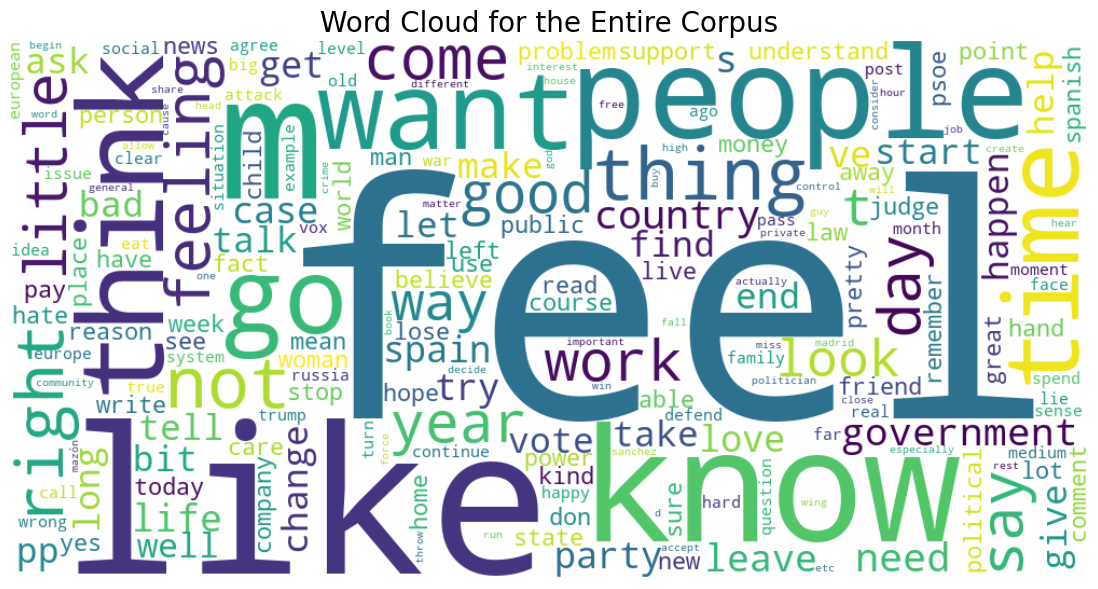

In [215]:
corpus_word_counts = Counter()
for bow_vec in data_bow:
    for word_id, count in bow_vec:
        corpus_word_counts[D[word_id]] += count

wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(corpus_word_counts)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for the Entire Corpus", fontsize=20)
plt.show()

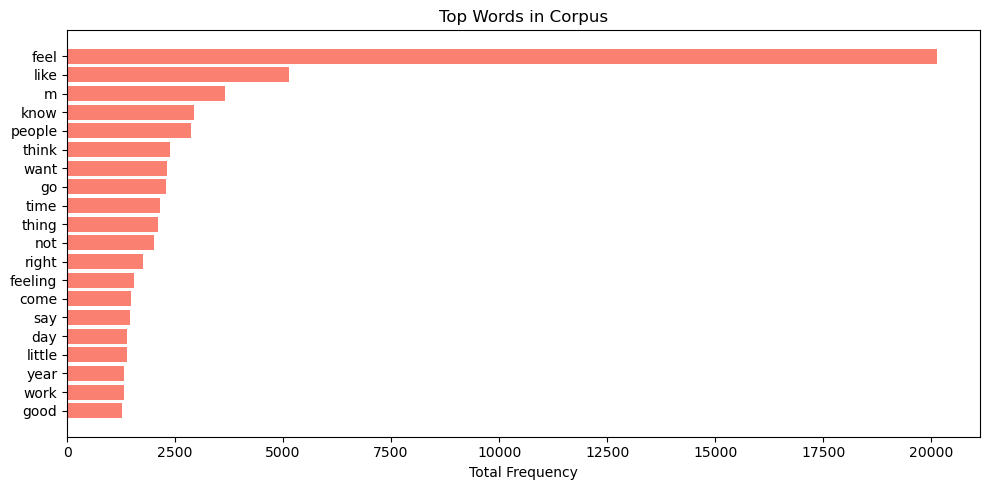

In [216]:
top_n = 20
common_words = corpus_word_counts.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 5))
plt.barh(words[::-1], counts[::-1], color='salmon')
plt.xlabel("Total Frequency")
plt.title("Top Words in Corpus")
plt.tight_layout()
plt.show()

### TF-IDF Representation

In [56]:
tfidf = TfidfModel(data_bow)

data_tfidf = tfidf[data_bow]
n_example = 4884
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(corpus[n_example])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[data_bow[n_example]])

============= TFIDF representation for the project =============
['feel', 'honored', 'shortlist', 'congratulate', 'wish', 'nominee', 'good', 'tonight', 'award', 'thank', 'age', 'scotland', 'kindness', 'div', 'class', 'intro', 'style', 'background', 'color', 'fff', 'color', 'font', 'family', 'trebuchet', 'ms', 'helvetica', 'bitstream', 'vera', 'san', 'san', 'serif', 'font', 'size']

============= TFIDF applying the transformation only to the document =============
[(0, 0.010320441472289568), (137, 0.06735960581047239), (147, 0.10570028627534063), (417, 0.09127241773865043), (582, 0.10129334056219905), (1241, 0.12275887487920925), (1294, 0.34666385033857544), (1495, 0.10138373185766794), (1557, 0.1395081341364112), (1621, 0.1340010849268276), (1791, 0.11799755208496988), (1858, 0.17057391730459287), (1868, 0.24869691463578036), (1872, 0.19083233549795148), (2013, 0.1254804873546644), (2638, 0.14130530001133115), (2693, 0.1462295314206462), (4793, 0.19083233549795148), (5141, 0.1802815499

#### Visualization

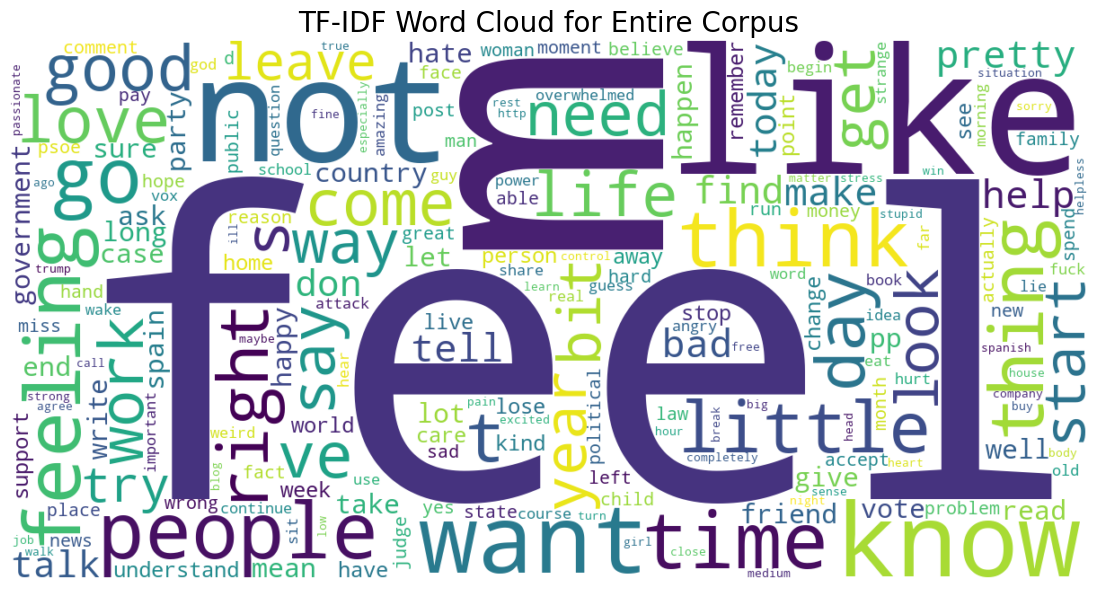

In [220]:
tfidf_scores = defaultdict(float)

for doc in data_tfidf:
    for word_id, score in doc:
        tfidf_scores[D[word_id]] += score

wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis')\
            .generate_from_frequencies(tfidf_scores)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("TF-IDF Word Cloud for Entire Corpus", fontsize=20)
plt.show()

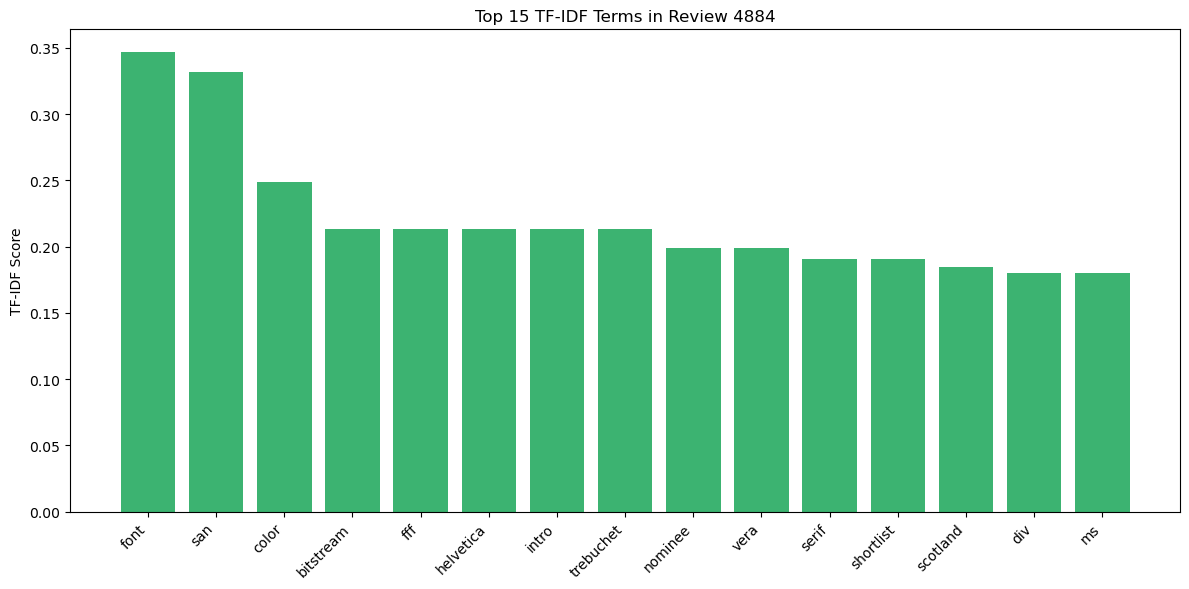

In [234]:
n_example = 4884
# Get TF-IDF values for one example
tfidf_vector = tfidf[data_bow[n_example]]
words_tfidf = [(D[word_id], score) for word_id, score in tfidf_vector]

top_n = 15
top_words = sorted(words_tfidf, key=lambda x: x[1], reverse=True)[:top_n]
words, scores = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, scores, color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel("TF-IDF Score")
plt.title(f"Top {top_n} TF-IDF Terms in example {n_example}")
plt.tight_layout()
plt.show()

### Word2Vec Representation

In [251]:
model_w2v = Word2Vec(sentences=corpus,vector_size=200,window=5,min_count=5,sg=1,seed=42)

In [254]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(model_w2v.wv.key_to_index)
print(words[0:50])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(model_w2v.wv[words[0]])


============= Word2Vec vocabulary =============
['feel', 'like', 'm', 'know', 'people', 'think', 'want', 'go', 'time', 'thing', 'not', 'right', 'feeling', 'come', 'say', 'day', 'little', 'year', 'work', 'good', 'way', 't', 'look', 'country', 'need', 'government', 'leave', 'life', 's', 'get', 'spain', 'love', 've', 'case', 'party', 'try', 'tell', 'make', 'pp', 'change', 'happen', 'bad', 'start', 'talk', 'end', 'find', 'take', 'vote', 'bit', 'help']

============= Embedding of the first word =============
[ 4.75391746e-01  5.02243459e-01 -1.56722069e-01  2.50074297e-01
 -4.28174511e-02  2.17278898e-02  1.75444067e-01  7.50041530e-02
 -7.24284872e-02 -1.44101635e-01 -9.12142694e-02  5.10690987e-01
 -9.38037336e-02  1.73291087e-01  1.61180183e-01 -2.22203918e-02
 -1.33988455e-01 -4.50255990e-01  2.56603748e-01 -1.22764744e-01
 -1.00593632e-02 -2.30259195e-01 -1.14437029e-01  6.30610168e-01
  2.19740301e-01 -3.50709669e-02  1.03144618e-02  1.84380710e-01
 -7.09610656e-02 -4.37015891e-01 -6

In [294]:
model_w2v.wv.most_similar(positive="sánchez")

[('pedro', 0.9708666801452637),
 ('sanchez', 0.9513913989067078),
 ('criticize', 0.9379637837409973),
 ('mazón', 0.9294793009757996),
 ('corrupt', 0.9202204942703247),
 ('president', 0.9157335758209229),
 ('aznar', 0.9043134450912476),
 ('minister', 0.8985118865966797),
 ('podemos', 0.8978269100189209),
 ('feijóo', 0.8962939977645874)]

#### Visualization

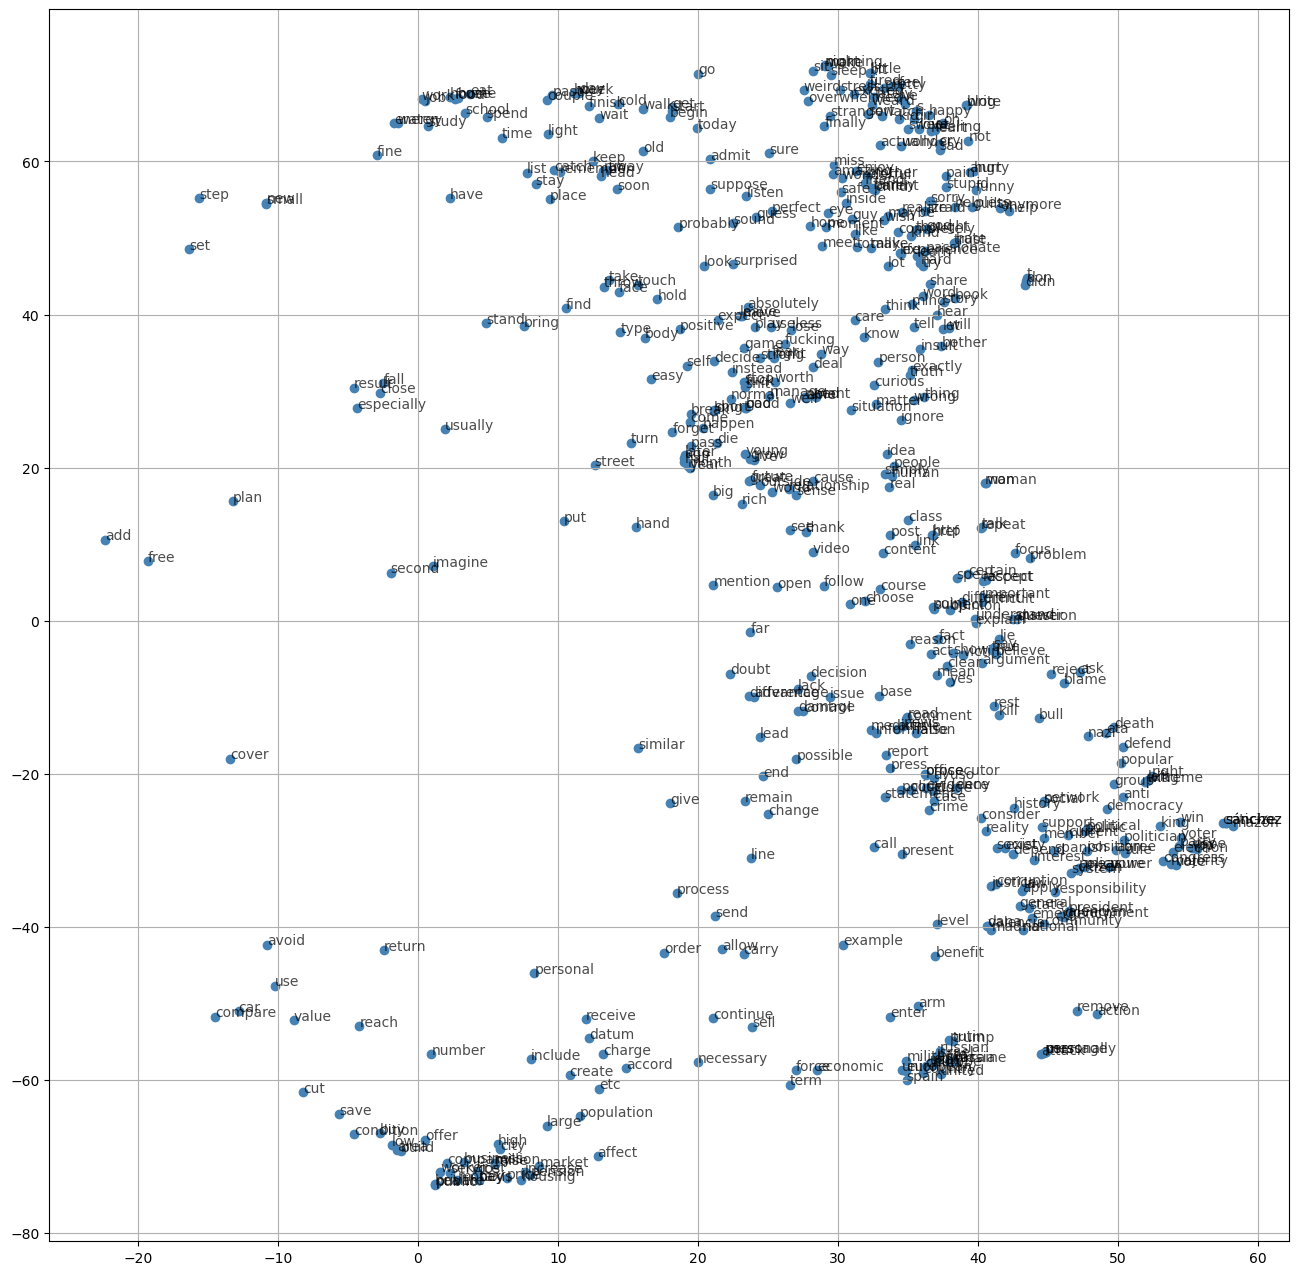

In [296]:
tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(model_w2v.wv.vectors)

fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(model_w2v.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

### FastText Representation

In [26]:
model_fasttext = FastText(sentences = corpus, vector_size = 200 ,min_count=10, window=5, seed=42)

In [28]:
model_fasttext.save("fasttext.ftz")

In [29]:
model_fasttext.wv.save("fasttext_word_vectors.kv")

In [27]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(model_fasttext.wv.key_to_index)
print(words[0:50])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(model_fasttext.wv[words[0]])


============= Word2Vec vocabulary =============
['feel', 'like', 'm', 'know', 'people', 'think', 'want', 'go', 'time', 'thing', 'not', 'right', 'feeling', 'come', 'say', 'day', 'little', 'year', 'work', 'good', 'way', 't', 'look', 'country', 'need', 'government', 'leave', 'life', 's', 'get', 'spain', 'love', 've', 'case', 'party', 'try', 'tell', 'make', 'pp', 'change', 'happen', 'bad', 'start', 'talk', 'end', 'find', 'take', 'vote', 'bit', 'help']

============= Embedding of the first word =============
[ 3.07538480e-01  7.20003843e-01 -3.24842483e-01  9.85824943e-01
 -2.55503327e-01 -1.38682082e-01  5.77101290e-01 -2.27735396e-02
  4.82464015e-01 -3.47469270e-01  4.03915904e-02 -3.83105367e-01
  2.21445307e-01  6.94983959e-01 -1.42257705e-01  3.38900417e-01
  4.82823290e-02 -2.61065494e-02 -4.76777941e-01  2.09357604e-01
 -8.36120769e-02  4.30961996e-01  5.13438731e-02 -2.97821552e-01
  6.48662895e-02  2.65214205e-01 -5.62529191e-02  3.15937102e-01
 -6.42173290e-01  1.48995847e-01 -9

In [322]:
model_fasttext.wv.most_similar(positive="sánchez")

[('authorize', 0.9996287226676941),
 ('apology', 0.9995877742767334),
 ('racism', 0.9995363354682922),
 ('sanchez', 0.9995230436325073),
 ('sue', 0.9995041489601135),
 ('junk', 0.999487578868866),
 ('justify', 0.9994638562202454),
 ('organize', 0.9994623064994812),
 ('andalusia', 0.999398410320282),
 ('argue', 0.999389111995697)]

#### Visualization

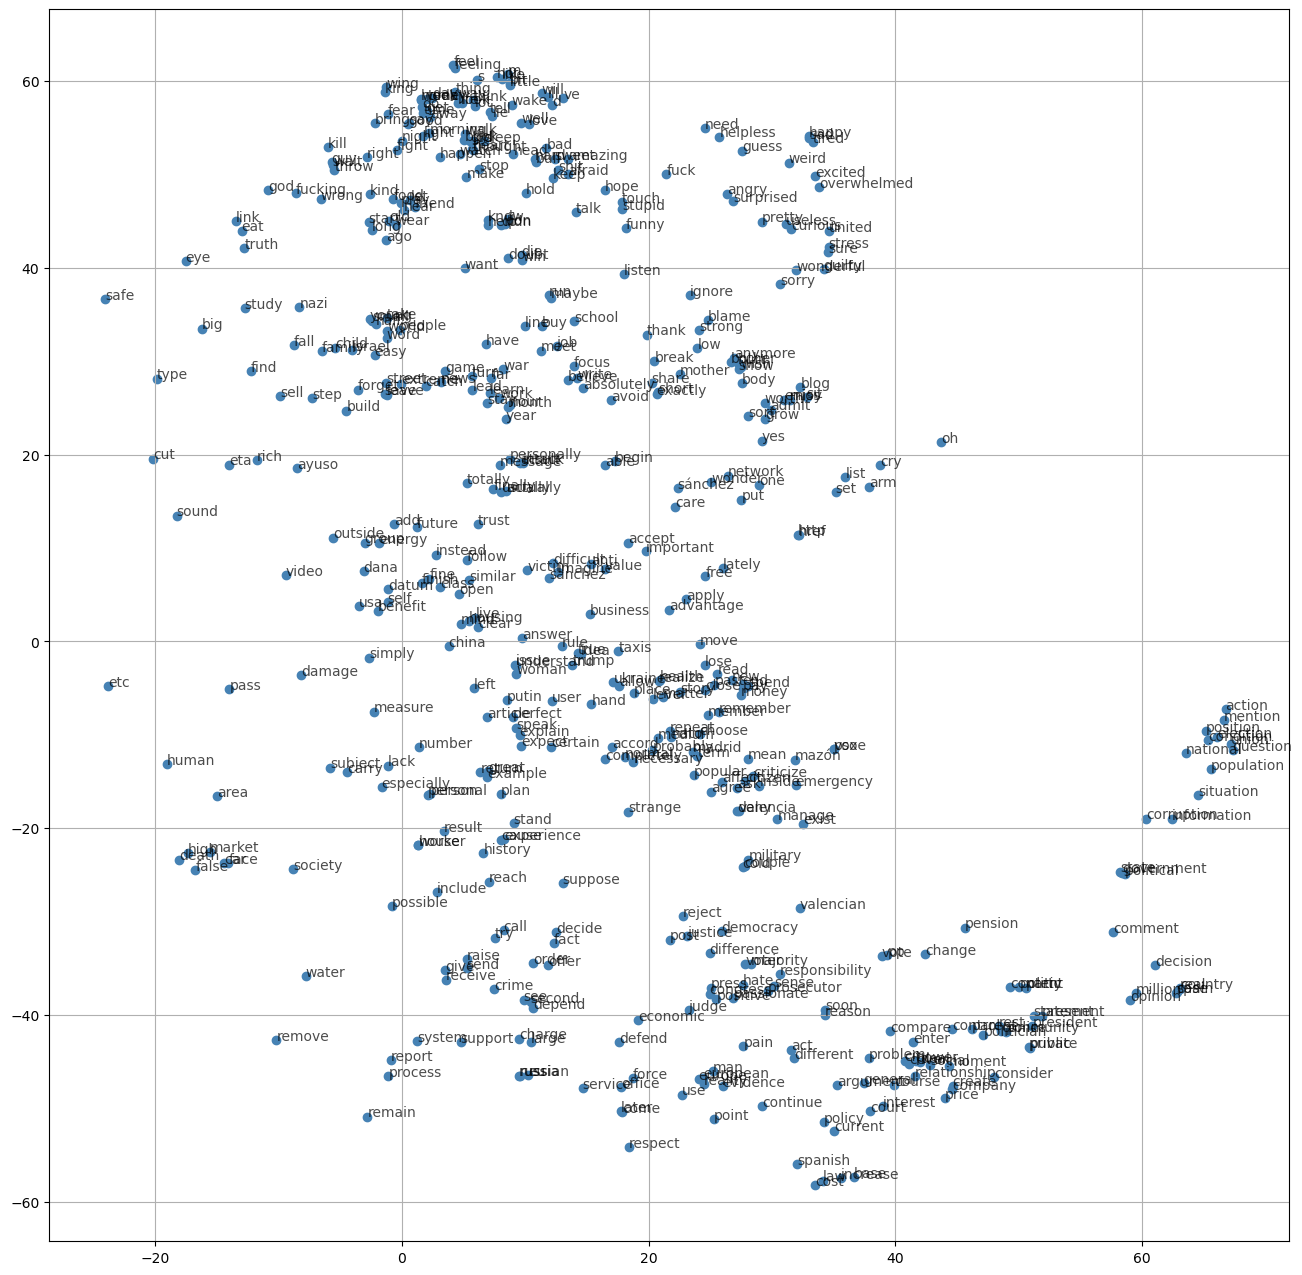

In [321]:
tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(model_fasttext.wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(model_fasttext.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

### Theme Extraction with LDA

For this section we will focus on obtaining the topics from our Reddit dataset as it is a problem that does not require of any label and it is more convinient to obtain relevant topics from this dataset 

First lets select the best amount of topics according to their coherence score

In [36]:
redditCorpus = redditData["tokens_english"].to_list()
redditD = Dictionary(redditCorpus)
reddit_bow  = [redditD.doc2bow(doc) for doc in redditCorpus]

In [335]:
n_topics = [5,10,15,20,25,50,100]
coherences = {}


for i in n_topics:
    
    ldag = LdaModel(corpus=reddit_bow, id2word=redditD, num_topics=i)
    coherencemodel = CoherenceModel(ldag, texts=redditCorpus, dictionary=redditD, coherence='c_v')
    coherences[f"{i}"] = coherencemodel.get_coherence()
    

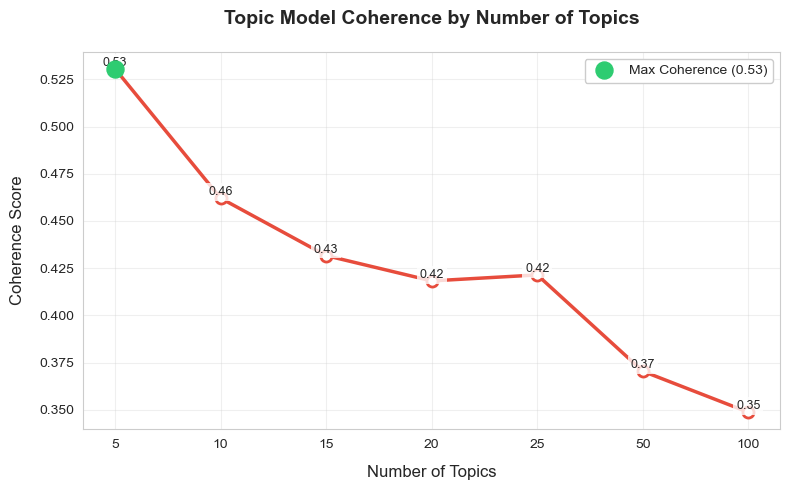

In [336]:
df = pd.DataFrame({"n_topics": coherences.keys(), "coherence": coherences.values()})

plt.figure(figsize=(8, 5))

ax = plt.plot(df["n_topics"], df["coherence"], c="#E74C3C", marker='o', markersize=8, linewidth=2.5, markerfacecolor='white', markeredgewidth=2)

plt.xlabel("Number of Topics", fontsize=12, labelpad=10)
plt.ylabel("Coherence Score", fontsize=12, labelpad=10)
plt.title("Topic Model Coherence by Number of Topics", 
          fontsize=14, pad=20, weight='bold')

plt.xticks(df["n_topics"], fontsize=10)
plt.yticks(fontsize=10)

for x, y in zip(df["n_topics"], df["coherence"]):
    plt.text(x, y, f'{y:.2f}', 
             ha='center', 
             va='bottom',
             fontsize=9,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

plt.grid(True, alpha=0.3)
plt.tight_layout()

max_coherence = df.loc[df['coherence'].idxmax()]
plt.scatter(max_coherence['n_topics'], max_coherence['coherence'], 
            color='#2ECC71', s=150, zorder=5, 
            label=f'Max Coherence ({max_coherence["coherence"]:.2f})')
plt.legend(fontsize=10, framealpha=1)

plt.show()

Even though the graph shows us that the best amount of topics is 5 we will use 10 in this case because we found out that we could obtain more specific topics this way

In [37]:
num_topics = 10
ldag = LdaModel(corpus=reddit_bow, id2word=redditD, num_topics=num_topics)

In [38]:
ldag[reddit_bow][100]

[(0, 0.012512401),
 (1, 0.012512702),
 (2, 0.012512869),
 (3, 0.01250837),
 (4, 0.012509468),
 (5, 0.012511566),
 (6, 0.7356607),
 (7, 0.16424881),
 (8, 0.01251147),
 (9, 0.012511645)]

In [39]:
ldag.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.012*"know" + 0.009*"want" + 0.008*"terrorist" + 0.007*"state" + 0.007*"thing" + 0.007*"bad" + 0.007*"psoe" + 0.007*"left" + 0.007*"party" + 0.007*"people"'),
 (1,
  '0.020*"pay" + 0.014*"people" + 0.013*"public" + 0.010*"price" + 0.010*"money" + 0.009*"year" + 0.008*"private" + 0.008*"want" + 0.008*"housing" + 0.007*"know"'),
 (2,
  '0.015*"go" + 0.011*"know" + 0.008*"government" + 0.008*"say" + 0.008*"de" + 0.008*"information" + 0.008*"case" + 0.007*"tell" + 0.007*"lie" + 0.007*"leak"'),
 (3,
  '0.018*"attack" + 0.017*"message" + 0.013*"withdraw" + 0.013*"user" + 0.012*"personally" + 0.010*"change" + 0.009*"aggressive" + 0.008*"insulting" + 0.008*"law" + 0.007*"journalist"'),
 (4,
  '0.013*"work" + 0.012*"change" + 0.010*"thing" + 0.008*"problem" + 0.007*"public" + 0.007*"people" + 0.007*"case" + 0.007*"pension" + 0.007*"come" + 0.007*"know"'),
 (5,
  '0.013*"government" + 0.011*"give" + 0.011*"emergency" + 0.009*"people" + 0.009*"pp" + 0.009*"vote" + 0.009*"say" + 0.008*"da

In [45]:
top_n = 30

topic_words = []
for topic_id in range(num_topics):
    top_words = [word for word, prob in ldag.show_topic(topic_id, topn=top_n)]
    topic_words.append(top_words)

# Create the DataFrame
df_topic_keywords = pd.DataFrame(topic_words, columns=[f"Word_{i+1}" for i in range(top_n)])
df_topic_keywords["Topic"] = df_topic_keywords.index

df_topic_keywords = df_topic_keywords[["Topic"] + [f"Word_{i+1}" for i in range(top_n)]]
df_topic_keywords.to_csv("topic_keywords.csv", index=False)

In [44]:
# Get topic distributions for each document
topic_distributions = [ldag.get_document_topics(doc, minimum_probability=0) for doc in reddit_bow]

# Convert to fixed-length dense vectors 
dense_distributions = [
    [prob for _, prob in sorted(doc_dist, key=lambda x: x[0])]
    for doc_dist in topic_distributions
]

# Get the index of the topic with the highest probability for each document
predominant_topics = [np.argmax(dist) for dist in dense_distributions]

df_topic_text = pd.DataFrame({
    "Document Index": range(len(reddit_bow)),
    "Predominant Topic": predominant_topics,
    "Topic Distribution": dense_distributions,
    "Text": redditData["text"]
})

df_topic_text.to_csv("reddit_lda_results.csv")

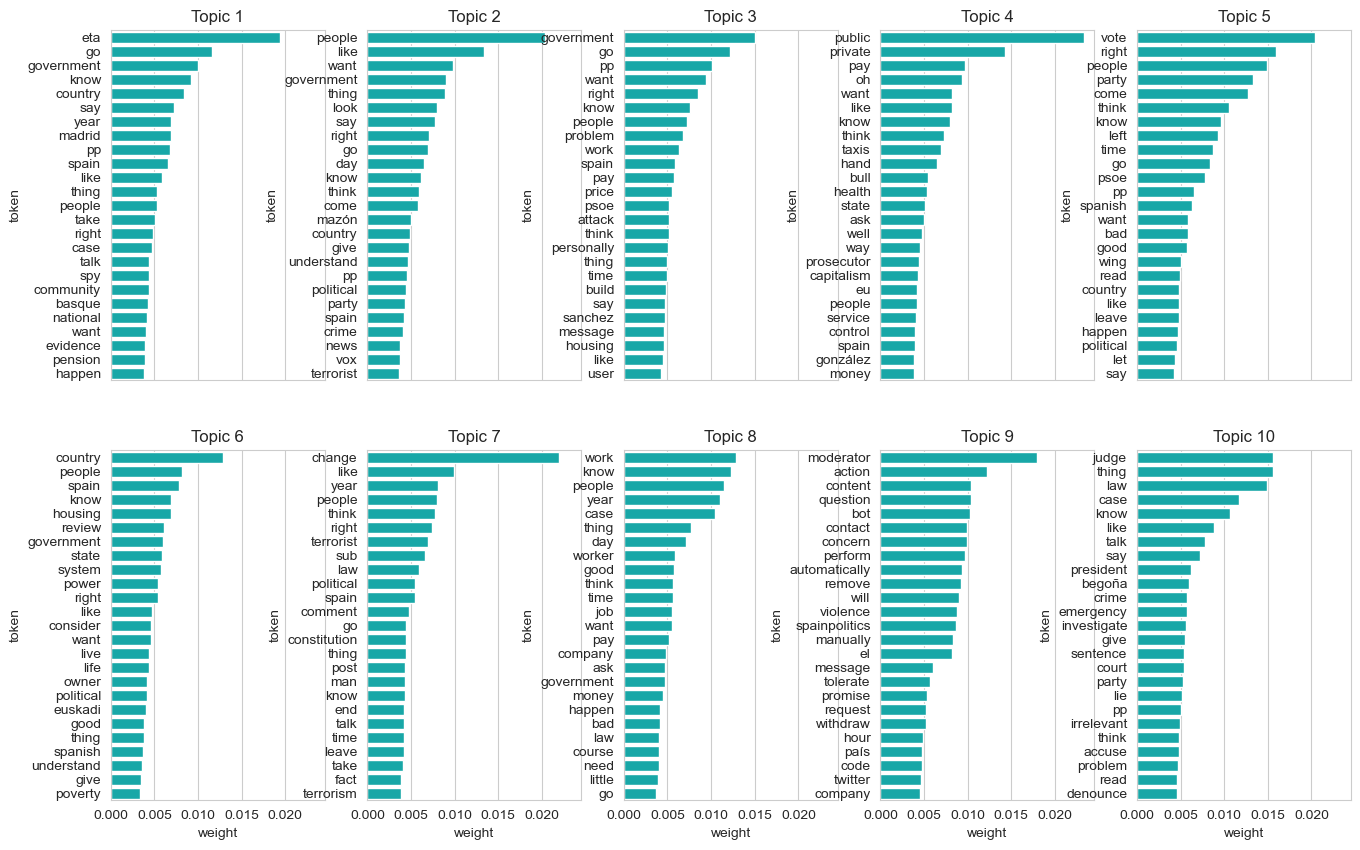

In [348]:
topn = 25
fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)

for i in range(5):
    # Topic i
    df = pd.DataFrame(data=ldag.show_topic(topicid=i, topn=topn), columns=["token", "weight"])
    sns.barplot(x='weight', y='token', data=df, color='c', ax=axes[0, i])
    axes[0, i].set_title(f'Topic {i + 1}')
        
    # Topic i + 5
    df = pd.DataFrame(data=ldag.show_topic(topicid=i + 5, topn=topn), columns=["token", "weight"])
    sns.barplot(x='weight', y='token', data=df, color='c', ax=axes[1, i])
    axes[1, i].set_title(f'Topic {i + 6}')

#### Visualization

In [362]:
df = pd.DataFrame(data=ldag.show_topic(topicid=5, topn=10), columns=["token", "weight"])

In [363]:
df["token"]

0       country
1        people
2         spain
3          know
4       housing
5        review
6    government
7         state
8        system
9         power
Name: token, dtype: object

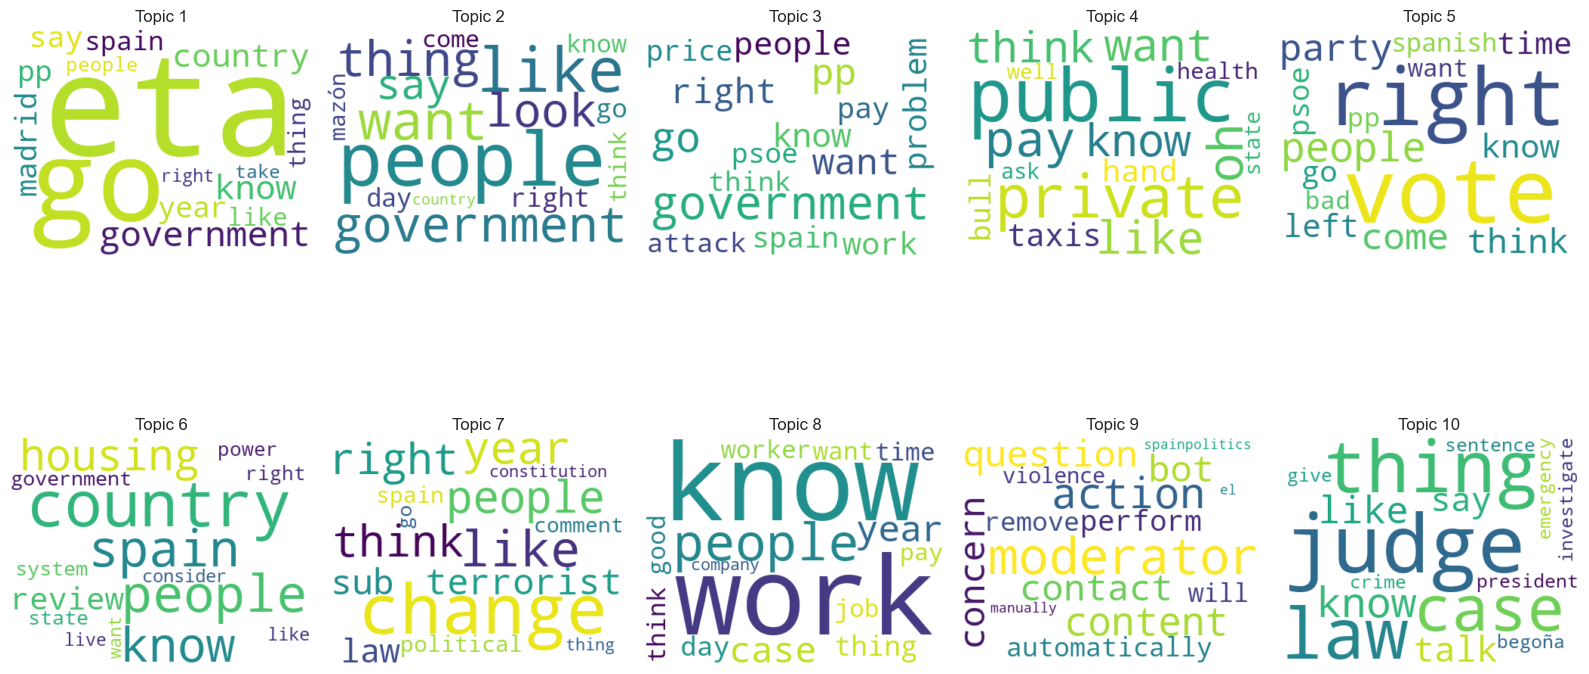

In [365]:
topn = 15
fig, axes = plt.subplots(2, 5, figsize=(16, 10))

for i in range(5):
    # Topic i
    topic_words = dict(ldag.show_topic(topicid=i, topn=topn))
    wc = WordCloud(background_color='white', width=400, height=300)
    wc.generate_from_frequencies(topic_words)
    axes[0, i].imshow(wc, interpolation='bilinear')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Topic {i + 1}')
        
    # Topic i + 5
    topic_words = dict(ldag.show_topic(topicid=i + 5, topn=topn))
    wc = WordCloud(background_color='white', width=400, height=300)
    wc.generate_from_frequencies(topic_words)
    axes[1, i].imshow(wc, interpolation='bilinear')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Topic {i + 6}')

plt.tight_layout()
plt.show()

Here we can see how the topic extraction can detect currrent trending topics in the politcal sphere of Spain as topic3 can be ralted to problems with the current goverment like the rise of prices, for topic 5 might be related to the elections in 2023 as it mentions the words "vote", "pp" and "psoe" which are the main political parties in Spain, topic 6 can be related to the housing problem that most of Spain is facing right now and topic 10 is clearly reltaed to the recent scandal of President Pedro Sanchez wife Begoña Gómez 

The topic extraction reveals the following information inside the corpus:

* **Topic 3**:  Economic Challenges and Government Criticism \
\
    This topic can be related to the public discontent with the current goverment's handling of economic issues , particularly the rising cost of living.

*  **Topic 5**: Electoral Day \
\
    The presence of keywords such as "vote," "PP," and "PSOE" suggests a relationship on Spain's 2023 elections where "pp" and "psoe" are the main political parties in Spain

   
*  **Topic 6**: Housing  and Power Crisis \
\
    One of the main problems in Spain right now is the lack of affordable housing and the rise of power prices ever since the Russia-Ukraine war started this topic seems to cluster all the words related to these topics.

* **Topic 10**: The Begoña Gómez Investigation \
\
  This topic relates to the investigation involving Begoña Gómez, the wife of president Pedro Sánchez. In April 2024, Gómez became the subject of a judicial inquiry over allegations of influence peddling and corruption, following complaints by anti-corruption organizations even though no conclusive evidence has been found far-right parties are really concerned about this topic

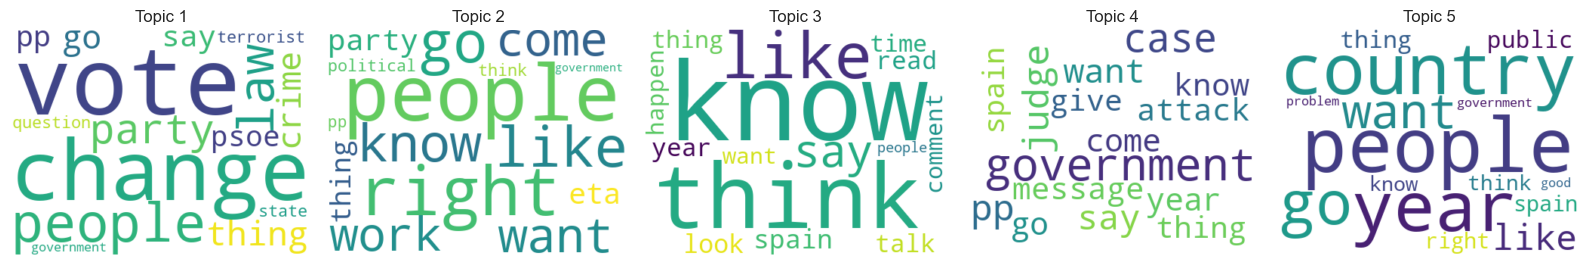

In [367]:
num_topics = 5
ldag = LdaModel(corpus=reddit_bow, id2word=redditD, num_topics=num_topics)

topn = 15
fig, axes = plt.subplots(1, 5, figsize=(16, 10))

for i in range(5):
    # Topic i
    topic_words = dict(ldag.show_topic(topicid=i, topn=topn))
    wc = WordCloud(background_color='white', width=400, height=300)
    wc.generate_from_frequencies(topic_words)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Topic {i + 1}')

plt.tight_layout()
plt.show()

## **4. Classification Task**

Our approach for the classification will be the following:

First we will split all the data with its corresponding tf-idf, bow, word2vec and fasttext representation to train two different classes of classifiers:

1. **Classic Classifiers**: We use the BoW and TF - IDF representations to fit a pipeline of SVM, RF ann KNN classifiers with hyperparameter selection using k-cross validation.
   
2. **Attention LSTM**: In order to preserve the infromation from the word embeddings obtained with word2vec and fasttext we will use this RNN model.

Then with the best model out all of them we will predict the labels for each one of the documents in our Reddit dataset

But first lets have a look of our labeled data and the proportion of each of the classes

In [368]:
fullDF

text  label  \
0                                i didnt feel humiliated      0   
1      i can go from feeling so hopeless to so damned...      0   
2       im grabbing a minute to post i feel greedy wrong      3   
3      i am ever feeling nostalgic about the fireplac...      2   
4                                   i am feeling grouchy      3   
...                                                  ...    ...   
19995  i just keep feeling like someone is being unki...      3   
19996  im feeling a little cranky negative after this...      3   
19997  i feel that i am useful to my people and that ...      1   
19998  im feeling more comfortable with derby i feel ...      1   
19999  i feel all weird when i have to meet w people ...      4   

                                                  tokens  lengths  
0                                 [not, feel, humiliate]        3  
1         [feel, hopeless, damned, hopeful, care, awake]        6  
2           [m, grab, minute, post, feel, greedy, wrong]        7  
3           [feel, nostalgic, fireplace, know, property]        5  
4                                        [feel, grouchy]        2  
...                                                  ...      ...  
19995  [feel, like, unkind, wrong, think, people, close]        7  
19996  [m, feel, little, cranky, negative, doctor, ap...        7  
19997  [feel, useful, people, give, great, feeling, a...        7  
19998  [m, feel, comfortable, derby, feel, start, ste...        8  
19999  [feel, weird, meet, w, people, text, like, not...       12  

[20000 rows x 4 columns]

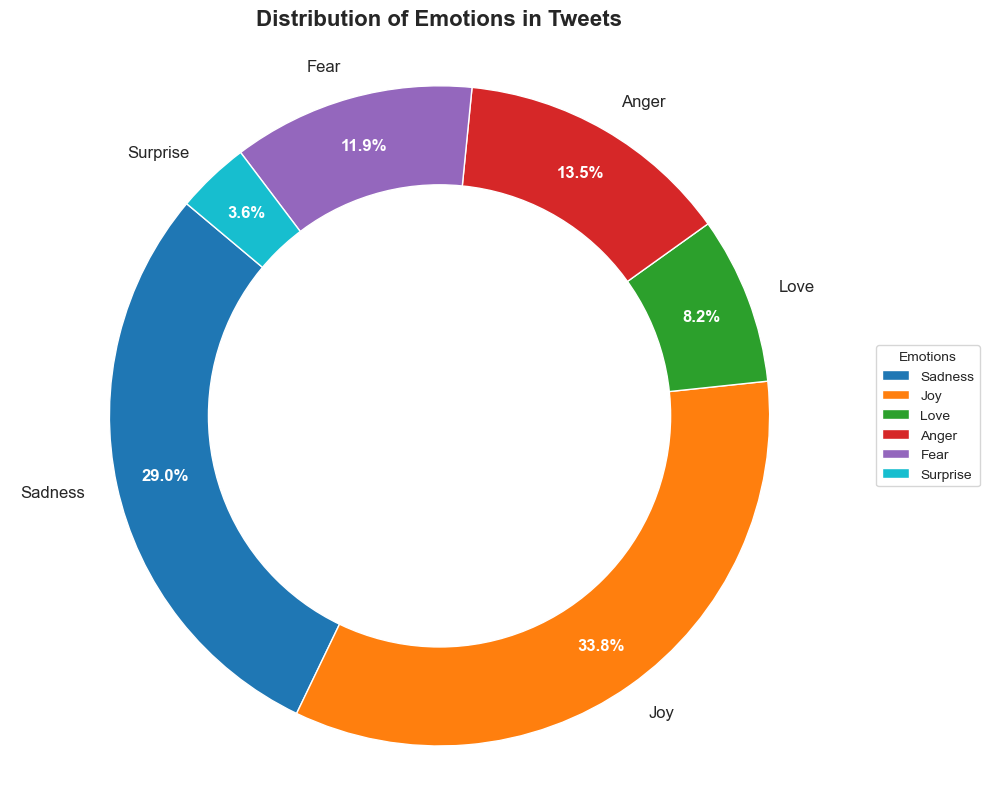

In [32]:
label_counts = fullDF['label'].value_counts().sort_index()

emotion_labels = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

colors = [
    '#1f77b4',  # Sadness (blue)
    '#ff7f0e',  # Joy (orange)
    '#2ca02c',  # Love (green)
    '#d62728',  # Anger (red)
    '#9467bd',  # Fear (purple)
    '#17becf'   # Surprise (cyan)
]

labels = [emotion_labels[i] for i in label_counts.index]
sizes = label_counts.values

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    pctdistance=0.85
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

plt.title('Distribution of Emotions in Tweets', 
          fontsize=16, 
          fontweight='bold', 
          pad=20)

plt.legend(
    wedges,
    labels,
    title="Emotions",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.tight_layout()
plt.show()

### Split the Data into Training, Validation and Test

In [389]:
print(max(fullDF["lengths"]), max(redditData["english_lengths"]))

34 206


In [407]:
redditData[["tokens_english","english_lengths"]][redditData["english_lengths"] < 35]

tokens_english  english_lengths
0      [greco, report, spain, corruption, prevention,...               10
2      [judge, peinado, fine, begoña, gomez, lawyer, ...               12
3      [man, need, little, house, time, time, bad, pl...               11
6      [farewell, unfished, school, canteen, industri...               11
9      [necessary, measure, tobacco, child, solution,...               14
...                                                  ...              ...
12744  [genuine, question, happen, vox, clearly, viol...                8
12745  [news, vox, change, podemos, orbán, maduro, hu...               23
12746  [surprise, esperanza, aguirre, paniaguado, orb...                7
12749  [happen, law, happen, like, rest, fail, happen...               20
12751  [good, thing, podemos, independence, banking, ...               13

[9240 rows x 2 columns]

In [404]:
redditData.loc[6508,"tokens_english"]

['truth',
 'idea',
 'turn',
 'essential',
 'health',
 'money',
 'waste',
 'purpose',
 'turn',
 'incredible',
 'assume',
 'alternative',
 'public',
 'health',
 'incentive',
 'party',
 'cut',
 'public',
 'million',
 'subsidy',
 'private',
 'company',
 'likewise',
 'fully',
 'efficient',
 'public',
 'health',
 'system',
 'imply',
 'necessary',
 'disappearance',
 'private',
 'health',
 'care',
 'pay',
 'private',
 'service',
 'public',
 'well',
 'fast',
 'private',
 'health',
 'advocate',
 'mean',
 'people',
 'political',
 'business',
 'interest',
 'relate',
 'interest',
 'public',
 'health',
 'improve',
 'work',
 'bad',
 'improvement',
 'public',
 'health',
 'condemn',
 'private',
 'health',
 'extinction',
 'existence',
 'private',
 'health',
 'care',
 'solve',
 'public',
 'health',
 'problem',
 'add',
 'excuse',
 'make',
 'sustainable',
 'wealthy',
 'people',
 'dodge',
 'bureaucracy',
 'wait',
 'condemns',
 'afford',
 'second',
 'class',
 'system',
 'lucrative',
 'alternative',
 'point',

The following cells of code will retrieve all the data from the bow, tfidf, word2vec and fasttext representations for each of our datasets then they will be removed and will be loaded whenever they are needed as these files are really heavy on our machines RAM.

In [417]:
def get_embeddings_for_corpus(model, corpus, garbage_token, maxlen=35):
    vector_size = model.vector_size
    garbage_vector = model.wv[garbage_token.text] if garbage_token.text in model.wv else np.zeros(vector_size)

    padded_embeddings = []
    for sentence in corpus:
        sentence_vectors = [model.wv[word] for word in sentence if word in model.wv]
        # Pad if needed
        if len(sentence_vectors) < maxlen:
            pad_len = maxlen - len(sentence_vectors)
            sentence_vectors.extend([garbage_vector] * pad_len)
        else:
            sentence_vectors = sentence_vectors[:maxlen]
        padded_embeddings.append(sentence_vectors)

    return np.array(padded_embeddings)

def get_fasttext_embeddings(model, corpus, garbage_token, maxlen=35):
    vector_size = model.vector_size
    garbage_vector = model.wv[garbage_token.text] if garbage_token.text in model.wv else np.zeros(vector_size)

    padded_embeddings = []
    for sentence in corpus:
        sentence_vectors = [model.wv[word] for word in sentence]
        # Pad if needed
        if len(sentence_vectors) < maxlen:
            pad_len = maxlen - len(sentence_vectors)
            sentence_vectors.extend([garbage_vector] * pad_len)
        else:
            sentence_vectors = sentence_vectors[:maxlen]
        padded_embeddings.append(sentence_vectors)

    return np.array(padded_embeddings)

In [418]:
# Train ------------------------------------

## Bow
train_bow = data_bow[0:lenTrain]

## TF- IDF
train_tfidf = data_tfidf[0:lenTrain]

## Doc2vec
garbage_token = nlp('#')
train_word2vec = get_embeddings_for_corpus(model_w2v, corpus[0:lenTrain], garbage_token)

## FastText
train_fasttext = get_fasttext_embeddings(model_fasttext, corpus[0:lenTrain], garbage_token)

In [428]:
# Save BOW
joblib.dump(train_bow, 'train_bow.pkl')

# Save TF-IDF
joblib.dump(train_tfidf, 'train_tfidf.pkl')

# Save Word2Vec
joblib.dump(train_word2vec, 'train_word2vec.pkl')

# Save FastText
joblib.dump(train_fasttext, 'train_fasttext.pkl')


['train_fasttext.pkl']

In [429]:
del train_bow, train_tfidf, train_word2vec, train_fasttext
gc.collect()

294583

In [435]:
# Validation -------------------------------

## Bow
validation_bow = data_bow[lenTrain:lenTrain+lenValidation]

## TF- IDF
validation_tfidf = data_tfidf[lenTrain:lenTrain+lenValidation]

## Doc2vec
validation_word2vec = get_embeddings_for_corpus(model_w2v, corpus[lenTrain:lenTrain+lenValidation], garbage_token)

## FastText
validation_fasttext = get_fasttext_embeddings(model_fasttext, corpus[lenTrain:lenTrain+lenValidation], garbage_token)

In [437]:
# Save BOW
joblib.dump(validation_bow, 'validation_bow.pkl')

# Save TF-IDF
joblib.dump(validation_tfidf, 'validation_tfidf.pkl')

# Save Word2Vec
joblib.dump(validation_word2vec, 'validation_word2vec.pkl')

# Save FastText
joblib.dump(validation_fasttext, 'validation_fasttext.pkl')

['validation_fasttext.pkl']

In [438]:
del validation_bow, validation_tfidf, validation_word2vec, validation_fasttext
gc.collect()

961

In [450]:
# Test -------------------------------------

## Bow
test_bow = data_bow[lenTrain+lenValidation:lenTrain+lenValidation+lenTest]

## TF- IDF
test_tfidf = data_tfidf[lenTrain+lenValidation:lenTrain+lenValidation+lenTest]

## Doc2vec
test_word2vec = get_embeddings_for_corpus(model_w2v, corpus[lenTrain+lenValidation:lenTrain+lenValidation+lenTest], garbage_token)

## FastText
test_fasttext = get_fasttext_embeddings(model_fasttext, corpus[lenTrain+lenValidation:lenTrain+lenValidation+lenTest], garbage_token)

In [451]:
# Save BOW
joblib.dump(test_bow, 'test_bow.pkl')

# Save TF-IDF
joblib.dump(test_tfidf, 'test_tfidf.pkl')

# Save Word2Vec
joblib.dump(test_word2vec, 'test_word2vec.pkl')

# Save FastText
joblib.dump(test_fasttext, 'test_fasttext.pkl')

['test_fasttext.pkl']

In [452]:
del test_bow, test_tfidf, test_word2vec, test_fasttext
gc.collect()

1263

In [457]:
# Reddit -------------------------------------

## Bow
reddit_bow = data_bow[lenTrain+lenValidation+lenTest:]

## TF- IDF
reddit_tfidf = data_tfidf[lenTrain+lenValidation+lenTest:]

## Doc2vec
reddit_word2vec = get_embeddings_for_corpus(model_w2v, corpus[lenTrain+lenValidation+lenTest:], garbage_token)

## FastText
reddit_fasttext = get_fasttext_embeddings(model_fasttext, corpus[lenTrain+lenValidation+lenTest:], garbage_token)

In [455]:
# Save BOW
joblib.dump(reddit_bow, 'reddit_bow.pkl')

# Save TF-IDF
joblib.dump(reddit_tfidf, 'reddit_tfidf.pkl')

# Save Word2Vec
joblib.dump(reddit_word2vec, 'reddit_word2vec.pkl')

# Save FastText
joblib.dump(reddit_fasttext, 'reddit_fasttext.pkl')

['reddit_fasttext.pkl']

In [459]:
del reddit_bow, reddit_tfidf, reddit_word2vec, reddit_fasttext
gc.collect()

0

In [460]:
del model_w2v, model_fasttext, data_bow, data_tfidf
gc.collect()

1278

In [15]:
y_train = np.array(fullDF["label"][0:lenTrain])
y_valid = np.array(fullDF["label"][lenTrain:lenTrain+lenValidation])
y_test = np.array(fullDF["label"][lenTrain+lenValidation:])

### Classic Classification 

Once all the necesary data handling is done we now load the BoW and Tf - Idf representations of the data to train a SVM, KNN and RF pipeline

#### BoW

In [15]:
train_bow = joblib.load('data/train_bow.pkl')
validation_bow = joblib.load('data/validation_bow.pkl')
test_bow = joblib.load('data/test_bow.pkl')

len_train = np.array(fullDF["lengths"][:lenTrain])
len_valid = np.array(fullDF["lengths"][lenTrain:lenTrain+lenValidation])
len_test = np.array(fullDF["lengths"][lenTrain+lenValidation:])

In [53]:
n_tokens = len(D)
num_docs = len(data_bow)

denseCorpus = corpus2csc(data_bow, num_terms=n_tokens, num_docs=num_docs).T
X_train = denseCorpus[:lenTrain]
X_test =  denseCorpus[lenTrain+lenValidation:lenTrain+lenValidation+lenTest]
del(denseCorpus)

y_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

models = [
    ("SVM", SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    ("KNN", KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    ("RandomForest", RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10]
    })
]

results = []

for name, model, param_grid in models:
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')

    results.append({
        'Classifier': name,
        'Best_Params': best_params,
        'Accuracy': acc,
        'AUC_Macro': auc
    })

results_df_bow = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df_bow)


Running GridSearchCV for SVM...
Running GridSearchCV for KNN...
Running GridSearchCV for RandomForest...

Final Results:
     Classifier                                Best_Params  Accuracy  \
0           SVM             {'C': 0.1, 'kernel': 'linear'}    0.8600   
1           KNN  {'n_neighbors': 3, 'weights': 'distance'}    0.5735   
2  RandomForest   {'max_depth': None, 'n_estimators': 100}    0.8650   

   AUC_Macro  
0   0.981108  
1   0.806775  
2   0.983131  


In [16]:
del(train_bow)
del(validation_bow)
del(test_bow)

In [68]:
results_df_bow

Classifier                                Best_Params  Accuracy  \
0           SVM             {'C': 0.1, 'kernel': 'linear'}    0.8600   
1           KNN  {'n_neighbors': 3, 'weights': 'distance'}    0.5735   
2  RandomForest   {'max_depth': None, 'n_estimators': 100}    0.8650   

   AUC_Macro  
0   0.981108  
1   0.806775  
2   0.983131

#### Tf - Idf

In [17]:
train_tfidf = joblib.load('data/train_tfidf.pkl')
validation_tfidf = joblib.load('data/validation_tfidf.pkl')
test_tfidf = joblib.load('data/test_tfidf.pkl')

len_train = np.array(fullDF["lengths"][:lenTrain])
len_valid = np.array(fullDF["lengths"][lenTrain:lenTrain+lenValidation])
len_test = np.array(fullDF["lengths"][lenTrain+lenValidation:])

In [57]:
n_tokens = len(D)
num_docs = len(data_bow)

denseCorpus = corpus2csc(data_tfidf, num_terms=n_tokens, num_docs=num_docs).T
X_train = denseCorpus[:lenTrain]
X_test =  denseCorpus[lenTrain+lenValidation:lenTrain+lenValidation+lenTest]
del(denseCorpus)

# Binarize y for AUC (needed for multiclass)
y_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

models = [
    ("SVM", SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    ("KNN", KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    ("RandomForest", RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10]
    })
]

results = []

for name, model, param_grid in models:
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')

    results.append({
        'Classifier': name,
        'Best_Params': best_params,
        'Accuracy': acc,
        'AUC_Macro': auc
    })

results_df_tfidf = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df_tfidf)

Running GridSearchCV for SVM...
Running GridSearchCV for KNN...
Running GridSearchCV for RandomForest...

Final Results:
     Classifier                                Best_Params  Accuracy  \
0           SVM               {'C': 1, 'kernel': 'linear'}    0.8615   
1           KNN  {'n_neighbors': 7, 'weights': 'distance'}    0.8260   
2  RandomForest   {'max_depth': None, 'n_estimators': 100}    0.8580   

   AUC_Macro  
0   0.982663  
1   0.951727  
2   0.983974  


In [69]:
results_df_tfidf

Classifier                                Best_Params  Accuracy  \
0           SVM               {'C': 1, 'kernel': 'linear'}    0.8615   
1           KNN  {'n_neighbors': 7, 'weights': 'distance'}    0.8260   
2  RandomForest   {'max_depth': None, 'n_estimators': 100}    0.8580   

   AUC_Macro  
0   0.982663  
1   0.951727  
2   0.983974

# Feature Extraction

As the best resulsts were obtained with BoW we now perform PCA on the dataset to see if we can further improve the results. We have chosen 100 features because even though a Elbow plot may suggest using around 20 variables the results are really poor and using more than a 100 features become a really heavy task for our machine 

In [97]:
from sklearn.decomposition import PCA

N_feats = 100
denseCorpus = corpus2csc(data_tfidf, num_terms=n_tokens, num_docs=num_docs).T
my_pca = PCA(n_components = N_feats).fit(denseCorpus)

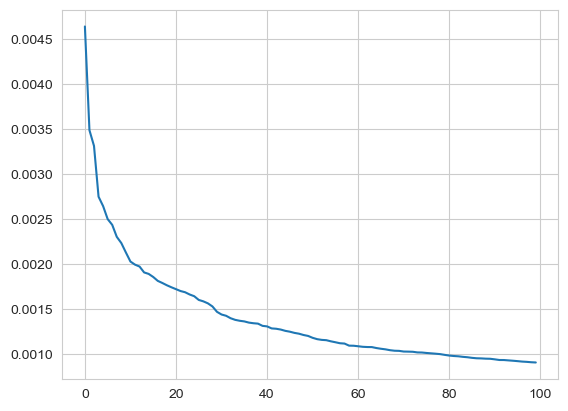

In [98]:
# Analyze eigenvalues
eigenvalues = my_pca.explained_variance_
plt.figure()
plt.plot(eigenvalues, label='Evolution eigenvalues')
plt.show()

In [99]:
tfidf_data_pca = my_pca.transform(denseCorpus)
tfidf_data_pca = bow_data_pca.astype(np.float16)

In [100]:
denseCorpus

<30882x21991 sparse matrix of type '<class 'numpy.float64'>'
	with 349182 stored elements in Compressed Sparse Row format>

In [105]:
print("PCA shape:", tfidf_data_pca.shape)

PCA shape: (30882, 50)


In [106]:
X_train = tfidf_data_pca[:lenTrain]
X_test =  tfidf_data_pca[lenTrain+lenValidation:lenTrain+lenValidation+lenTest]

# Binarize y for AUC
y_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

models = [
    ("SVM", SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    ("KNN", KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    ("RandomForest", RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10]
    })
]

results = []

for name, model, param_grid in models:
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average='macro')

    results.append({
        'Classifier': name,
        'Best_Params': best_params,
        'Accuracy': acc,
        'AUC_Macro': auc
    })

results_df_tfidf_pca = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df_tfidf_pca)


Running GridSearchCV for SVM...
Running GridSearchCV for KNN...
Running GridSearchCV for RandomForest...

Final Results:
     Classifier                               Best_Params  Accuracy  AUC_Macro
0           SVM                 {'C': 1, 'kernel': 'rbf'}    0.3755   0.574489
1           KNN  {'n_neighbors': 7, 'weights': 'uniform'}    0.3665   0.588437
2  RandomForest    {'max_depth': 10, 'n_estimators': 100}    0.4010   0.616870


In [92]:
results_df_bow_pca

Classifier                               Best_Params  Accuracy  AUC_Macro
0           SVM                 {'C': 1, 'kernel': 'rbf'}    0.3755   0.574675
1           KNN  {'n_neighbors': 7, 'weights': 'uniform'}    0.3665   0.588437
2  RandomForest  {'max_depth': None, 'n_estimators': 100}    0.3960   0.610984

In [107]:
results_df_tfidf_pca

Classifier                               Best_Params  Accuracy  AUC_Macro
0           SVM                 {'C': 1, 'kernel': 'rbf'}    0.3755   0.574489
1           KNN  {'n_neighbors': 7, 'weights': 'uniform'}    0.3665   0.588437
2  RandomForest    {'max_depth': 10, 'n_estimators': 100}    0.4010   0.616870

### Classification with an Attention Model

As our project focuses on analyzing the public perception of Spanish politic landscape through sentiment analysis of text data to achieve this goal, we needed a robust text classification model capable of accurately categorizing noisy and context-dependent text from our Reddit dataset.

#### LSTM

Text data has a sequential structure by nature. The meaning of a sentence often depends not just on individual words but also on their order and how they relate with each other over a sequence. Recurrent Neural Networks (RNNs) were designed to handle such sequential data.

Long Short-Term Memory (LSTM) networks are a specific type of RNN that are particularly effective at learning long-term dependencies in sequences. Standard RNNs may suffer from the vanishing gradient problem, making it difficult for them to remember information from distant past steps in a sequence. LSTMs mitigate this through its gating mechanisms (input, forget, and output gates) that controls the flow of information, allowing them to selectively remember or forget information over the time.

Given the nature of Reddit comments and posts, which can vary in length and complexity, a LSTM's ability to capture these long-range dependencies makes it a strong candidate for understanding the full context of a given text.

Another reason on why we chose this model is the emphasis we gave to the translation of the text from spanish to english using a transformer so context wasn't lost in the process.

#### Enhancing it with Attention

Even though LSTMs are powerful, processing long sequences can still be challenging. A standard LSTM processes information  token by token and produces a final hidden state that is a fixed-size representation of the entire input sequence. This fixed representation can become a bottleneck, especially when dealing with very long texts where different parts of the text might be more relevant to the final classification than others.

This is where the attention mechanism imporves the architecture. Attention allows the model to dynamically assign weights to the importance of different parts of the input sequence when making a prediction. Instead of relying solely on the final hidden state of the LSTM, the attention mechanism computes a weighted sum of the hidden states across the entire sequence, where the weights are learned based on their relevance to the classification task.

In summary combining an LSTM with an attention mechanism offers these advantages:

1.  **Improved Focus:** The attention mechanism allows the model to concentrate on the most emotionally words. For example, in a long comment about political events, certain adjectives or descriptions might display the most emotional weight, and attention helps the model highlight these.
2.  **Handling Varying Lengths:** Attention helps the model effectively process text of different lengths.
3.  **State-of-the-Art Performance:** Attention mechanisms are considered a State-of-the-Art (SOTA) technique in various Natural Language Processing tasks, including text classification and sentiment analysis. And their improve in performance is notable compared to the same models without attention.

#### Using Word2Vec

In [18]:
train_word2vec = joblib.load('data/train_word2vec.pkl')
validation_word2vec = joblib.load('data/validation_word2vec.pkl')
test_word2vec = joblib.load('data/test_word2vec.pkl')

len_train = np.array(fullDF["lengths"][:lenTrain])
len_valid = np.array(fullDF["lengths"][lenTrain:lenTrain+lenValidation])
len_test = np.array(fullDF["lengths"][lenTrain+lenValidation:])

In [22]:
class RNN_attention(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5):
        super().__init__()

        # Automatically choose device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.n_layers = n_layers

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)

        # Attention 
		
        # 1st Layer: Input = Queries + Hidden State
        self.linear1 = nn.Linear(2*hidden_dim,hidden_dim)
        self.tanh = nn.Tanh()
        # 2nd Layer: Output = 1 (Sum of the Normalized weights * keys)
        self.linear2 = nn.Linear(hidden_dim,1)
        self.softmax = nn.Softmax(dim = 1)

        # Fully-connected output layer
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=prob)

        # Move all layers to the selected device
        self.to(self.device)

    def forward(self, x, lengths, h0=None):

        lengths = [min(l, 35) for l in lengths]

        batch_size = x.size(0)
        seq_length = x.size(1)

        x = x.to(self.device)
        if h0 is not None:
            h0 = (h0[0].to(self.device), h0[1].to(self.device))

        # Compute the RNN output (sequence of states for the whole input) h to hl

        r_out, _ = self.rnn(x, h0)

        # Query (Should be Hidden State l before junk tokens)

        queries = torch.stack([r_out[d, lengths[d] - 1, :] for d in range(batch_size)])
        keys = r_out

        queries = queries.unsqueeze(1)
        queries_expanded = queries.expand(-1, keys.size(1), -1) # Shape: (N, S, H)
        queries_flat = queries_expanded.reshape(-1, keys.size(2))
        keys_flat = keys.reshape(-1, keys.size(2))
        inputs = torch.cat([queries_flat, keys_flat], dim=1)

        unnormalized_weights = self.tanh(self.linear1(inputs))
        unnormalized_weights = self.linear2(unnormalized_weights).squeeze(-1) # Now shape is (N*S,)		
        unnormalized_weights = unnormalized_weights.view(batch_size, seq_length) # Now shape is (N,S)

        mask = torch.arange(seq_length, device=self.device).unsqueeze(0) >= torch.tensor(lengths, device=self.device).unsqueeze(1)
        unnormalized_weights.masked_fill_(mask, float('-inf'))
     
        alphas = self.softmax(unnormalized_weights)
        alphas_expanded = alphas.unsqueeze(-1).expand(-1, -1, keys.size(2))

        c = torch.sum(alphas_expanded * keys, dim=1)
        output = self.logsoftmax(self.fc1(self.dropout(c)))

        return output, alphas


class RNN_attention_with_train(RNN_attention):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0,
                 batch_size=50, lr=0.0005, saved_files='./saved_models/RNN_sentiment_analysis'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        os.makedirs(os.path.dirname(saved_files), exist_ok=True)
        self.saved_files = saved_files

   
    def predict_proba(self, docs, lengths, Y=None):
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.stack([torch.tensor(d, dtype=torch.float32) for d in docs]).to(self.device)
            logprobs, weights = self.forward(x_input, lengths)
            logprobs = logprobs.cpu().detach().numpy()

            if Y is not None and len(Y) > 0:
                accuracy = np.sum(np.argmax(logprobs, 1) == Y) / np.shape(Y)[0]

        return logprobs, accuracy


    def fit(self, docs_train, docs_val, Y, Yval, len_train, len_val, epochs=100, print_every=5):
        self.print_every = print_every
        self.epochs = epochs
        self.num_train = len(docs_train)
        self.num_batchs = int(np.floor(self.num_train / self.batch_size))
        self.num_val = len(docs_val)
        self.num_batchs_val = int(np.floor(self.num_val / self.batch_size))
    
        labels = torch.tensor(Y, dtype=torch.long, device=self.device)
        labelsval = torch.tensor(Yval, dtype=torch.long, device=self.device)
    
        for e in range(self.epochs):
            self.train()
            idx = np.random.permutation(self.num_train)
            running_loss = 0.
            start_time = time.time()
    
            for i in range(self.num_batchs):
                self.optim.zero_grad()
                idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]
                idx_batch = [d for d in idx_batch if len_train[d] > 0]
    
                # Convert docs to tensors
                x_input = torch.stack([torch.tensor(docs_train[d], dtype=torch.float32) for d in idx_batch]).to(self.device)
                out, _ = self.forward(x_input, [len_train[d] for d in idx_batch])
                loss = self.criterion(out, labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                self.optim.step()
    
            self.loss_during_training.append(running_loss / self.num_batchs)
            torch.save(self.state_dict(), self.saved_files + f'_epoch_{e}.pth')
    
            # Validation
            self.eval()
            with torch.no_grad():
                running_loss = 0.
                idx = np.random.permutation(self.num_val)
                for i in range(self.num_batchs_val):
                    idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]
                    idx_batch = [d for d in idx_batch if len_val[d] > 0]
    
                    # Convert docs to tensors for validation
                    x_input = torch.stack([torch.tensor(docs_val[d], dtype=torch.float32) for d in idx_batch]).to(self.device)
                    out, _ = self.forward(x_input, [len_val[d] for d in idx_batch])
                    loss = self.criterion(out, labelsval[idx_batch])
                    running_loss += loss.item()
    
                self.valid_loss_during_training.append(running_loss / self.num_batchs_val)
    
            if (e+1) % self.print_every == 0:
                print(f"============================ Epoch: {e + 1}, Time: {time.time() - start_time} ============================")
                print(f"Training Loss = {self.loss_during_training[-1]}  |  Validation Loss = {self.valid_loss_during_training[-1]}")


55 epochs

In [37]:
my_RNN = RNN_attention_with_train(input_size=200, output_size=6, hidden_dim=256, n_layers=4)

In [38]:
my_RNN.fit(train_word2vec, validation_word2vec, y_train, y_valid, len_train, len_valid, epochs=20, print_every=5)

============================ Epoch: 5, Time: 14.108459711074829 ============================
Training Loss = 1.233372356928885  |  Validation Loss = 1.2129264071583747
============================ Epoch: 10, Time: 13.84563946723938 ============================
Training Loss = 0.7701551391743123  |  Validation Loss = 0.7380799174308776
============================ Epoch: 15, Time: 13.745363235473633 ============================
Training Loss = 0.38841711771674453  |  Validation Loss = 0.4753248505294323
============================ Epoch: 20, Time: 13.837274551391602 ============================
Training Loss = 0.2618099993327633  |  Validation Loss = 0.45447945296764375


In [87]:
my_RNN.fit(train_word2vec, validation_word2vec, y_train, y_valid, len_train, len_valid, epochs=5, print_every=1)

============================ Epoch: 1, Time: 14.01301097869873 ============================
Training Loss = 0.12344471192627679  |  Validation Loss = 0.5892657030373811
============================ Epoch: 2, Time: 13.188293933868408 ============================
Training Loss = 0.1204694801417645  |  Validation Loss = 0.5011070344597102
============================ Epoch: 3, Time: 13.448501110076904 ============================
Training Loss = 0.1113836392221856  |  Validation Loss = 0.581323417648673
============================ Epoch: 4, Time: 13.430422067642212 ============================
Training Loss = 0.0982976118917577  |  Validation Loss = 0.534381153434515
============================ Epoch: 5, Time: 13.197872877120972 ============================
Training Loss = 0.09904970000789035  |  Validation Loss = 0.5829546689987183


In [88]:
logprobs_test, accuracy_test = my_RNN.predict_proba(test_word2vec,len_test,y_test)

In [89]:
accuracy_test

0.858

#### Check Performance

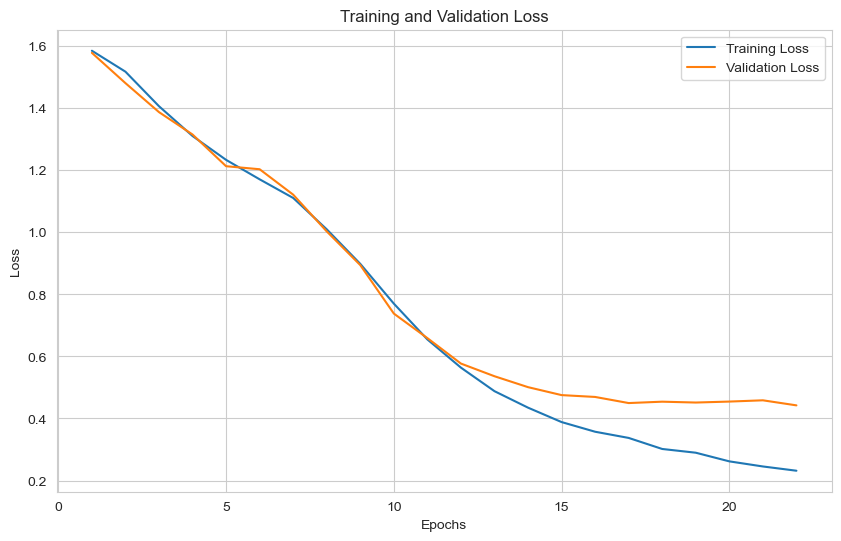

In [47]:
# Plotting the train/val loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(my_RNN.loss_during_training) + 1), my_RNN.loss_during_training, label='Training Loss')
plt.plot(range(1, len(my_RNN.valid_loss_during_training) + 1), my_RNN.valid_loss_during_training, label='Validation Loss')

# Labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

The model starts to overfit so for now on we will use a previus version of this model before it started to overfit at epoch 27

In [67]:
my_RNN = torch.load("models/sligltlyBetterFULLMODELattentionLSTM.pth")

C:\Users\iqbal\AppData\Local\Temp\ipykernel_13260\2114691596.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_RNN = torch.load("sligltlyBetterFULLMODELattentionLSTM.pt

In [52]:
my_RNN

RNN_attention_with_train(
  (rnn): LSTM(200, 256, num_layers=4, batch_first=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (tanh): Tanh()
  (linear2): Linear(in_features=256, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc1): Linear(in_features=256, out_features=6, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.0, inplace=False)
  (criterion): NLLLoss()
)

In [51]:
logprobs_test, accuracy_test = my_RNN.predict_proba(test_word2vec,len_test,y_test)
accuracy_test

0.861

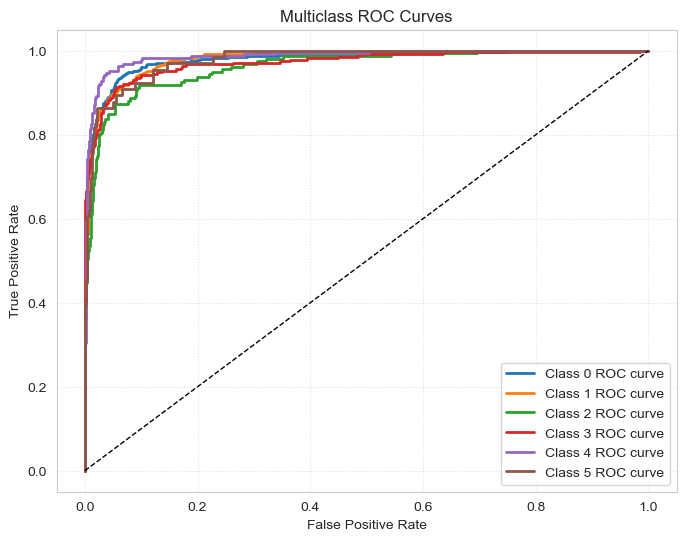

AUC ROC (macro average) for LSTM: 0.9768


In [50]:
# Get log-probabilities and accuracy from your RNN model
logprobs, acc = my_RNN.predict_proba(test_word2vec, len_test, y_test)

# Convert log-probabilities to actual probabilities
probs = np.exp(logprobs)

# Convert test labels to numpy array
y_test_np = np.array(y_test)

# One-hot encode true labels for ROC AUC calculation
n_classes = probs.shape[1]
y_test_onehot = label_binarize(y_test_np, classes=np.arange(n_classes))

# Remove samples with NaNs in either labels or predicted probs
mask = ~np.isnan(y_test_onehot).any(axis=1) & ~np.isnan(probs).any(axis=1)
y_test_clean = y_test_onehot[mask]
probs_clean = probs[mask]

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = metrics.roc_curve(y_test_clean[:, i], probs_clean[:, i])
    ax.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve')

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curves')
ax.legend(loc='lower right')
ax.grid(True, linestyle='dotted', alpha=0.6)
plt.show()

# Compute macro AUC ROC score
area_roc_LSTM = metrics.roc_auc_score(
    y_test_clean,
    probs_clean,
    multi_class='ovr',
    average='macro'
)
print(f"AUC ROC (macro average) for LSTM: {area_roc_LSTM:.4f}")


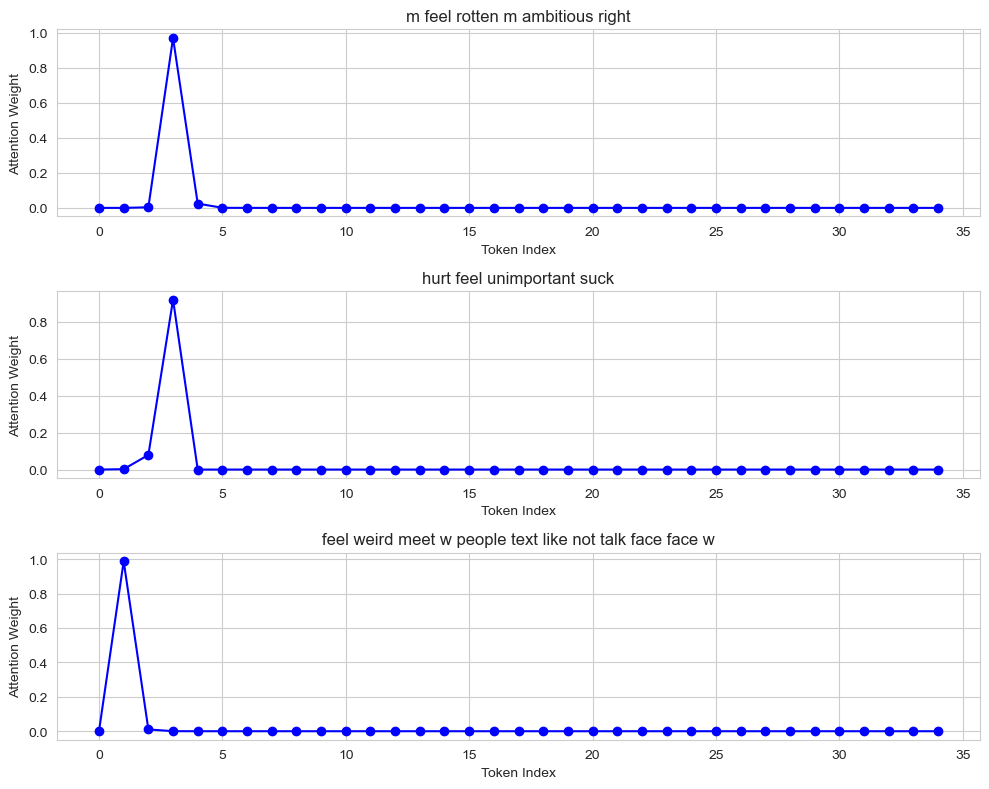

In [94]:
idx_example_1 = 0  
idx_example_2 = 999
idx_example_3 = 1999


x_input_example_1 = torch.Tensor([[w for w in test_word2vec[idx_example_1]]])
x_input_example_2 = torch.Tensor([[w for w in test_word2vec[idx_example_2]]])
x_input_example_3 = torch.Tensor([[w for w in test_word2vec[idx_example_3]]])

_, attention_weights_1 = my_RNN(x_input_example_1, [len_test[idx_example_1]])
_, attention_weights_2 = my_RNN(x_input_example_2, [len_test[idx_example_2]])
_, attention_weights_3 = my_RNN(x_input_example_3, [len_test[idx_example_3]])


# Squeeze and convert to lists
attention_weights_1_values = attention_weights_1.squeeze().tolist()
attention_weights_2_values = attention_weights_2.squeeze().tolist()
attention_weights_3_values = attention_weights_3.squeeze().tolist()

x1 = list(range(len(attention_weights_1_values)))
x2 = list(range(len(attention_weights_2_values)))
x3 = list(range(len(attention_weights_3_values)))


plt.figure(figsize=(10, 8))

# First subplot
plt.subplot(3, 1, 1)
plt.plot(x1, attention_weights_1_values, 'bo-')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title(f'{" ".join(token for token in fullDF.loc[18000 + idx_example_1,"tokens"] if token != "#")}')

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(x2, attention_weights_2_values, 'bo-')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title(f'{" ".join(token for token in fullDF.loc[18000 + idx_example_2,"tokens"] if token != "#")}')

# Third subplot
plt.subplot(3, 1, 3)
plt.plot(x3, attention_weights_3_values, 'bo-')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title(f'{" ".join(token for token in fullDF.loc[18000 + idx_example_3,"tokens"] if token != "#")}')

plt.tight_layout()
plt.show()


In [ ]:
del train_word2vec,validation_word2vec,test_word2vec
gc.collect()

#### Using FastText

In [11]:
train_fasttext = joblib.load('data/train_fasttext.pkl')
validation_fasttext = joblib.load('data/validation_fasttext.pkl')
test_fasttext = joblib.load('data/test_fasttext.pkl')

len_train = np.array(fullDF["lengths"][:lenTrain])
len_valid = np.array(fullDF["lengths"][lenTrain:lenTrain+lenValidation])
len_test = np.array(fullDF["lengths"][lenTrain+lenValidation:])

In [16]:
my_RNN_ft = RNN_attention_with_train(input_size=200, output_size=6, hidden_dim=64, n_layers=4)
my_RNN_ft.fit(train_fasttext, validation_fasttext, y_train, y_valid, len_train, len_valid, epochs=50, print_every=5)

============================ Epoch: 5, Time: 9.080675601959229 ============================
Training Loss = 1.573833504319191  |  Validation Loss = 1.583145096898079
============================ Epoch: 10, Time: 8.90967607498169 ============================
Training Loss = 1.5411567129194736  |  Validation Loss = 1.5432323545217514
============================ Epoch: 15, Time: 9.468573570251465 ============================
Training Loss = 1.5138153459876775  |  Validation Loss = 1.5214713931083679
============================ Epoch: 20, Time: 9.052994012832642 ============================
Training Loss = 1.4598689265549183  |  Validation Loss = 1.4766798466444016
============================ Epoch: 25, Time: 8.975638151168823 ============================
Training Loss = 1.4076222203671933  |  Validation Loss = 1.444636917114258
============================ Epoch: 30, Time: 8.61577558517456 ============================
Training Loss = 1.3576437897980214  |  Validation Loss = 1.415133824

In [17]:
torch.save(my_RNN_ft, 'fasttextmodel.pth')

In [18]:
logprobs_test, accuracy_test = my_RNN_ft.predict_proba(test_fasttext,len_test,y_test)
accuracy_test

0.504

#### Check Performance

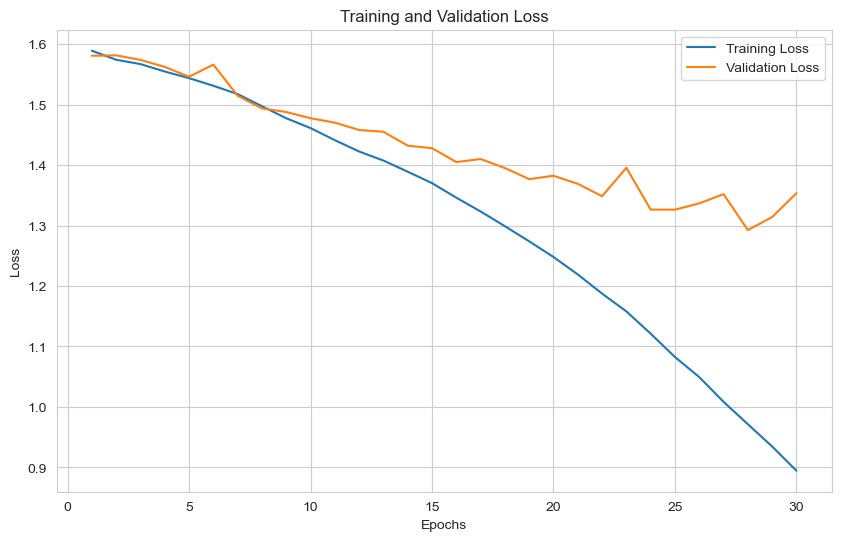

In [639]:
# Plotting the train/val loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(my_RNN_ft.loss_during_training) + 1), my_RNN_ft.loss_during_training, label='Training Loss')
plt.plot(range(1, len(my_RNN_ft.valid_loss_during_training) + 1), my_RNN_ft.valid_loss_during_training, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

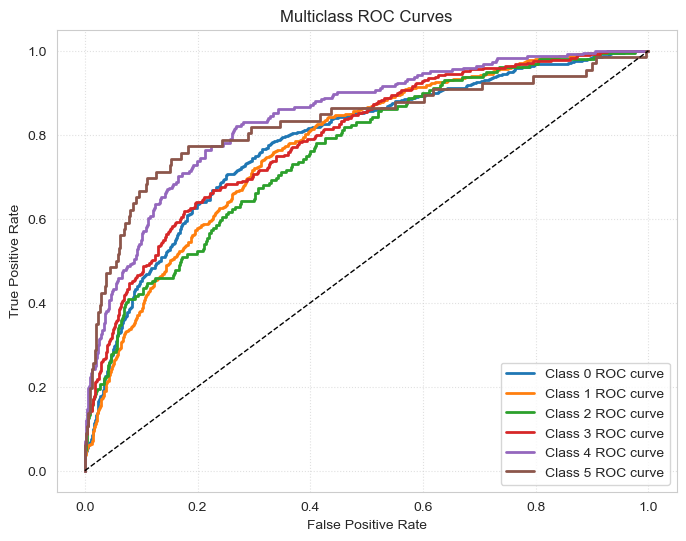

AUC ROC (macro average) for LSTM: 0.7958


In [642]:
logprobs, acc = my_RNN_ft.predict_proba(test_fasttext, len_test, y_test)

# Convert log-probabilities to actual probabilities
probs = np.exp(logprobs)

# Convert test labels to numpy array
y_test_np = np.array(y_test)

# One-hot encode true labels for ROC AUC calculation
n_classes = probs.shape[1]
y_test_onehot = label_binarize(y_test_np, classes=np.arange(n_classes))

# Remove samples with NaNs in either labels or predicted probs
mask = ~np.isnan(y_test_onehot).any(axis=1) & ~np.isnan(probs).any(axis=1)
y_test_clean = y_test_onehot[mask]
probs_clean = probs[mask]

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = metrics.roc_curve(y_test_clean[:, i], probs_clean[:, i])
    ax.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve')

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multiclass ROC Curves')
ax.legend(loc='lower right')
ax.grid(True, linestyle='dotted', alpha=0.6)
plt.show()

# Compute macro AUC ROC score
area_roc_LSTM = metrics.roc_auc_score(
    y_test_clean,
    probs_clean,
    multi_class='ovr',
    average='macro'
)
print(f"AUC ROC (macro average) for LSTM: {area_roc_LSTM:.4f}")


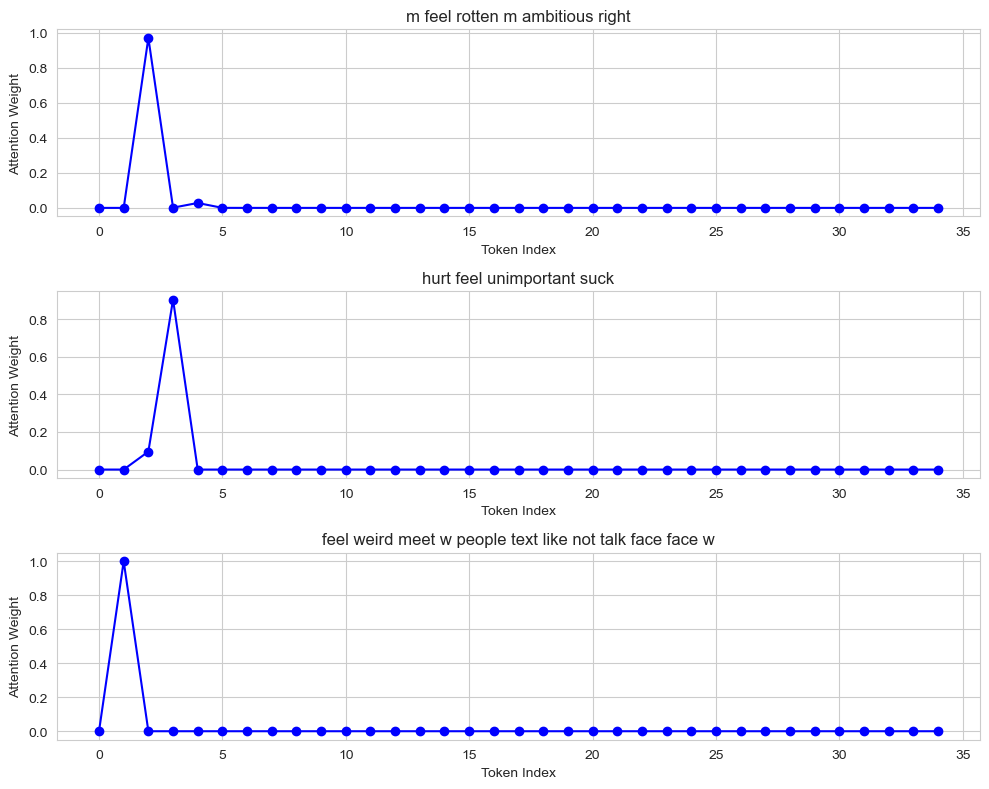

In [643]:
idx_example_1 = 0
idx_example_2 = 999
idx_example_3 = 1999


x_input_example_1 = torch.Tensor([[w for w in test_fasttext[idx_example_1]]])
x_input_example_2 = torch.Tensor([[w for w in test_fasttext[idx_example_2]]])
x_input_example_3 = torch.Tensor([[w for w in test_fasttext[idx_example_3]]])

_, attention_weights_1 = my_RNN_ft(x_input_example_1, [len_test[idx_example_1]])
_, attention_weights_2 = my_RNN_ft(x_input_example_2, [len_test[idx_example_2]])
_, attention_weights_3 = my_RNN_ft(x_input_example_3, [len_test[idx_example_3]])


# Squeeze and convert to lists
attention_weights_1_values = attention_weights_1.squeeze().tolist()
attention_weights_2_values = attention_weights_2.squeeze().tolist()
attention_weights_3_values = attention_weights_3.squeeze().tolist()

x1 = list(range(len(attention_weights_1_values)))
x2 = list(range(len(attention_weights_2_values)))
x3 = list(range(len(attention_weights_3_values)))

plt.figure(figsize=(10, 8)) 

# First subplot
plt.subplot(3, 1, 1)
plt.plot(x1, attention_weights_1_values, 'bo-')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title(f'{" ".join(token for token in fullDF.loc[18000 + idx_example_1,"tokens"] if token != "#")}')

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(x2, attention_weights_2_values, 'bo-')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title(f'{" ".join(token for token in fullDF.loc[18000 + idx_example_2,"tokens"] if token != "#")}')

# Third subplot
plt.subplot(3, 1, 3)
plt.plot(x3, attention_weights_3_values, 'bo-')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.title(f'{" ".join(token for token in fullDF.loc[18000 + idx_example_3,"tokens"] if token != "#")}')

plt.tight_layout()
plt.show()


In [ ]:
del train_fasttext,validation_fasttext,test_fasttext
gc.collect()

#### Performance Analysis

After several trainings of these 2 models we can see how the word2vec one is clearly superior the the one trained using the fasttext representation.

In the following table we show the side by side comparisons of the best models trained in each of the representations:

<table style="width: 80%; border-collapse: collapse; font-size: 18px; margin: 20px auto; text-align: center;">
  <thead>
    <tr style="background-color: #f2f2f2;">
      <th style="padding: 12px; border: 1px solid #ccc;">Model</th>
      <th style="padding: 12px; border: 1px solid #ccc;">Epochs</th>
      <th style="padding: 12px; border: 1px solid #ccc;">AUC</th>
      <th style="padding: 12px; border: 1px solid #ccc;">Test Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 12px; border: 1px solid #ccc;"><b>Word2Vec</b></td>
      <td style="padding: 12px; border: 1px solid #ccc;">27</td>
      <td style="padding: 12px; border: 1px solid #ccc;">0.9768</td>
      <td style="padding: 12px; border: 1px solid #ccc;">0.861</td>
    </tr>
    <tr>
      <td style="padding: 12px; border: 1px solid #ccc;"><b>FastText</b></td>
      <td style="padding: 12px; border: 1px solid #ccc;">30</td>
      <td style="padding: 12px; border: 1px solid #ccc;">0.7958</td>
      <td style="padding: 12px; border: 1px solid #ccc;">0.533</td>
    </tr>
  </tbody>
</table> 

## **5. Inference over Reddit Dataset**

Now that we have trained our best model is time to label our Reddit dataset in order to find out the general opinion of the goverment.

Firts we will obtain the labels for each one of the text in our dataset:

In [23]:
my_RNN = torch.load("models/sligltlyBetterFULLMODELattentionLSTM.pth")
reddit_w2v = joblib.load('data/reddit_word2vec.pkl')
reddit_lengths = np.array(redditData["english_lengths"])

C:\Users\iqbal\AppData\Local\Temp\ipykernel_7224\521152244.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_RNN = torch.load("models/sligltlyBetterFULLMODELattentionLS

In [24]:
log_probs, _ = my_RNN.predict_proba(reddit_w2v, reddit_lengths)
predicted_labels = np.argmax(log_probs, axis=1)

In [25]:
redditData["labels"] = predicted_labels

In [26]:
label_to_sentiment = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

redditData['sentiment'] = redditData['labels'].map(label_to_sentiment)
redditData['date'] = pd.to_datetime(redditData['created_utc'], unit='s')
redditData['year'] = redditData['date'].dt.year

In [27]:
redditData = redditData.reset_index(drop=True)
redditData.head(10)

created_utc                                               text  \
0  1.744820e+09  Informe GRECO sobre España: Corruption prevent...   
1  1.744841e+09  >that judges are to be elected by their peers ...   
2  1.744792e+09  El juez Peinado multa al abogado de Begoña Góm...   
3  1.744806e+09  Este hombre necesita una de casito de vez en c...   
4  1.744812e+09  Multa con 5000 al abogado de Begoña porque al ...   
5  1.744726e+09  Adiós a los 1.200 comedores escolares sin pesc...   
6  1.744789e+09  Más que necesaria medida, que ahora es como si...   
7  1.744728e+09  No te preocupes, que seguro que pronto aparece...   
8  1.744742e+09  Acabo de pasarme por LD y lo venden como una i...   
9  1.744791e+09  Si los niños tuviesen que alimentarse de lo qu...   

                                              tokens  lengths  \
0  [informe, greco, españa, corruption, preventio...       14   
1  [that, judg, are, to, be, elected, by, their, ...       54   
2  [juez, peinado, multa, abogado, begoña, gómez,...       12   
3  [hombre, necesitar, casito, lugar, dejar, juez...        7   
4  [multa, abogado, begoña, presentar, alegación,...       68   
5  [adiós, comedor, escolar, pescado, bollería, i...       11   
6  [necesario, medida, dar, tabaco, crío, solució...       15   
7  [preocupar, seguro, aparecer, hablar yo, liber...        6   
8  [acabar, pasar yo, ld, vender, intolerable, ag...       10   
9  [niño, tener, alimentar él, querer, salir, int...       37   

                                     translated_text  \
0  GRECO report on Spain: Corruption prevention i...   
1  >that judges are to be elected by their peer (...   
2  Judge Peinado fined Begoña Gomez's lawyer €5,0...   
3  This man needs a little house from time to tim...   
4  A fine of 5000 for Begoña's lawyer because by ...   
5  Farewell to 1,200 unfished school canteens and...   
6  More than necessary measure, that now it is as...   
7  Don't worry, I'm sure the usual ones will soon...   
8  I just passed through LD and they sell it as a...   
9  If children had to feed on what they wanted, t...   

                                      tokens_english  english_lengths  labels  \
0  [greco, report, spain, corruption, prevention,...               10       4   
1  [judge, elect, peer, follow, method, guarantee...               44       3   
2  [judge, peinado, fine, begoña, gomez, lawyer, ...               12       1   
3  [man, need, little, house, time, time, bad, pl...               11       0   
4  [fine, begoña, lawyer, present, argument, call...               73       3   
5  [farewell, unfished, school, canteen, industri...               11       1   
6  [necessary, measure, tobacco, child, solution,...               14       3   
7  [worry, sure, usual, one, soon, talk, freedom,...                9       3   
8  [pass, ld, sell, intolerable, aggression, free...                8       1   
9  [child, feed, want, leave, mcdonald, interest,...               40       3   

  sentiment                date  year  
0      fear 2025-04-16 16:13:14  2025  
1     anger 2025-04-16 22:07:33  2025  
2       joy 2025-04-16 08:28:50  2025  
3   sadness 2025-04-16 12:21:57  2025  
4     anger 2025-04-16 14:02:51  2025  
5       joy 2025-04-15 13:59:21  2025  
6     anger 2025-04-16 07:40:20  2025  
7     anger 2025-04-15 14:38:17  2025  
8       joy 2025-04-15 18:26:34  2025  
9     anger 2025-04-16 08:10:35  2025

In [83]:
joblib.dump(redditData, 'redditDataInference.pkl')
redditData.to_csv("redditDataInference.csv")


Once we have obtained the labels lets see some examples of each one of the 6 emotions and its attention weights visualizations 

In [28]:
example_indices = [6398,4404,7344,4271,7326,6140]

C:\Users\iqbal\AppData\Local\Temp\ipykernel_7224\585667588.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_input = torch.Tensor([[w for w in reddit_w2v[idx]]])


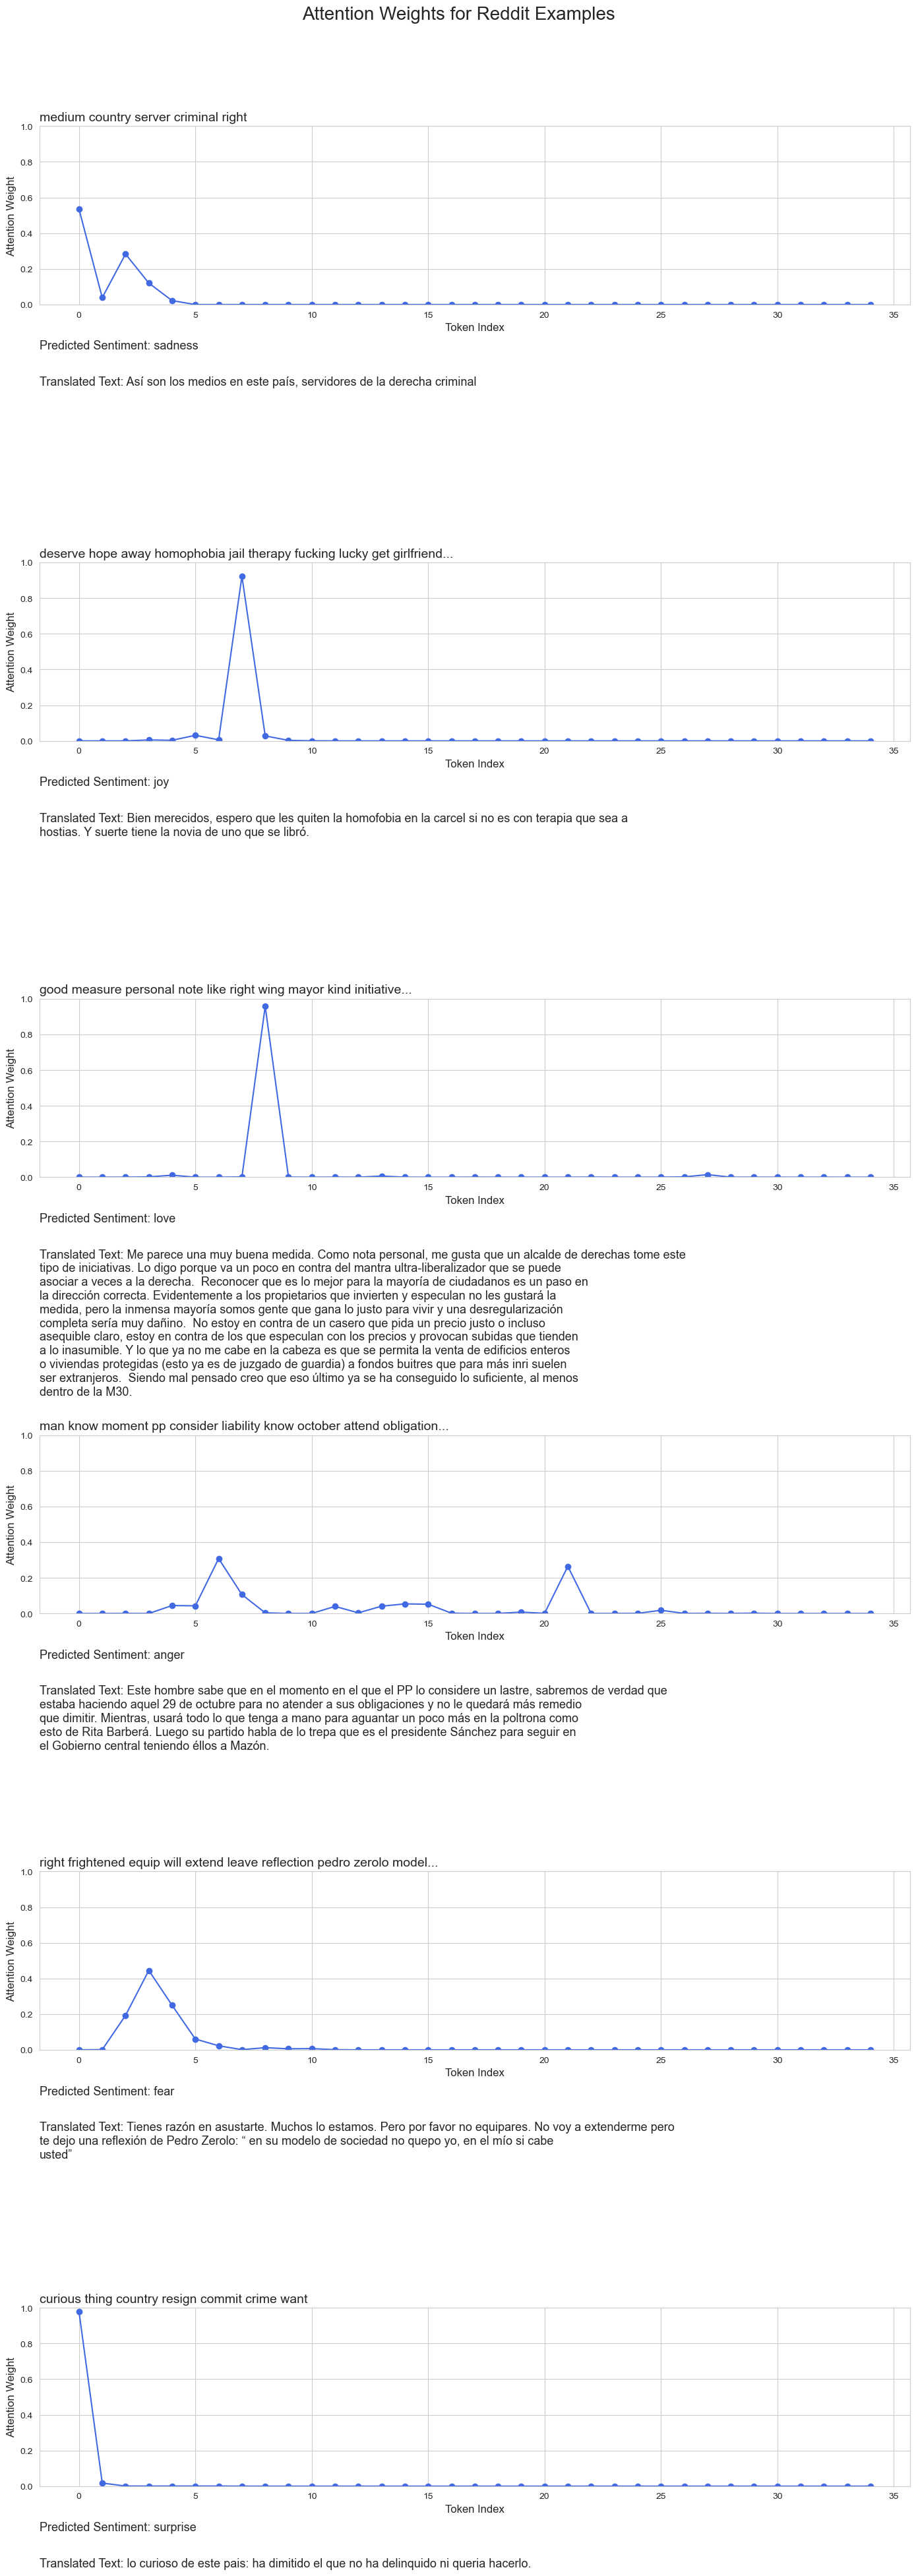

In [29]:
max_text_len = max(len(redditData.loc[idx, "translated_text"]) for idx in example_indices)
extra_height = max_text_len * 0.012  # Adjust this multiplier as needed

fig, axes = plt.subplots(len(example_indices), 1, 
                        figsize=(14, 5 * len(example_indices) + extra_height))

if len(example_indices) == 1:
    axes = [axes]

fig.suptitle("Attention Weights for Reddit Examples", fontsize=20, y=0.995)

for i, idx in enumerate(example_indices):
    ax = axes[i]

    # Prepare input and attention
    x_input = torch.Tensor([[w for w in reddit_w2v[idx]]])
    _, attention_weights = my_RNN(x_input, [reddit_lengths[idx]])
    attention_values = attention_weights.squeeze().tolist()
    x_vals = list(range(len(attention_values)))

    # Get text and label
    tokens = [t for t in redditData.loc[idx, "tokens_english"] if t != "#"]
    translated = redditData.loc[idx, "text"]
    sentiment = redditData.loc[idx, "sentiment"]

    # Plot
    ax.plot(x_vals, attention_values, marker='o', color='royalblue')
    ax.set_title(" ".join(tokens[:10]) + ("..." if len(tokens) > 10 else ""), fontsize=14, loc='left')
    ax.set_xlabel('Token Index', fontsize=12)
    ax.set_ylabel('Attention Weight', fontsize=12)
    ax.grid(True)
    ax.set_ylim(0, 1)
    
    # Adjust annotation positions
    ax.annotate(f"Predicted Sentiment: {sentiment}", xy=(0, -0.25), xycoords='axes fraction',
                fontsize=13, ha='left')
    wrapped_text = '\n'.join(textwrap.wrap(translated, width=100))  # Wrap long text
    ax.annotate(f"Translated Text: {wrapped_text}", xy=(0, -0.4), xycoords='axes fraction',
                fontsize=13, ha='left', va='top')

plt.subplots_adjust(hspace=0.8)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # More bottom space
plt.show()

Now lets see the proportion of each one of the sentiments in the dataset

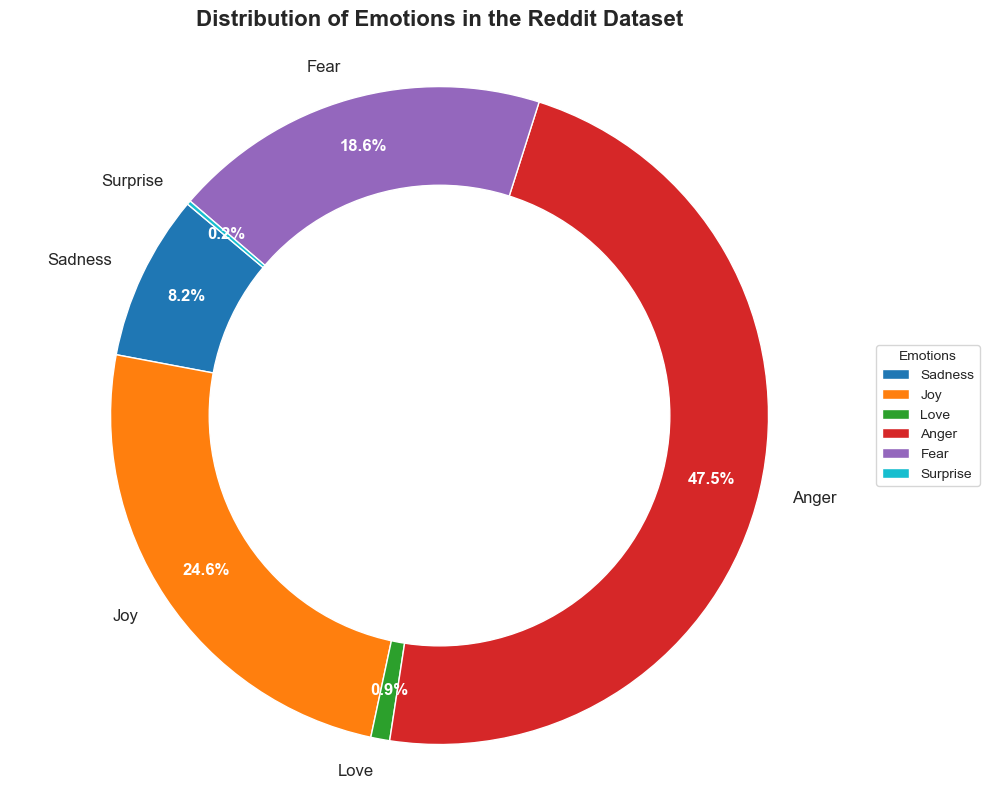

In [33]:
label_counts = redditData['labels'].value_counts().sort_index()

labels = [emotion_labels[i] for i in label_counts.index]
sizes = label_counts.values

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    pctdistance=0.85
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')

plt.title('Distribution of Emotions in the Reddit Dataset', 
          fontsize=16, 
          fontweight='bold', 
          pad=20)

plt.legend(
    wedges,
    labels,
    title="Emotions",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.tight_layout()
plt.show()

From this plot, we can observe how anger is the predominant emotion in the dataset, with nearly 50% of the texts predicted to express this sentiment.

Let's take a look at how the distribution in the pie chart changes across years. In our case, we only have data from 2024 to 2025, as this was the maximum range we were able to scrape and process.

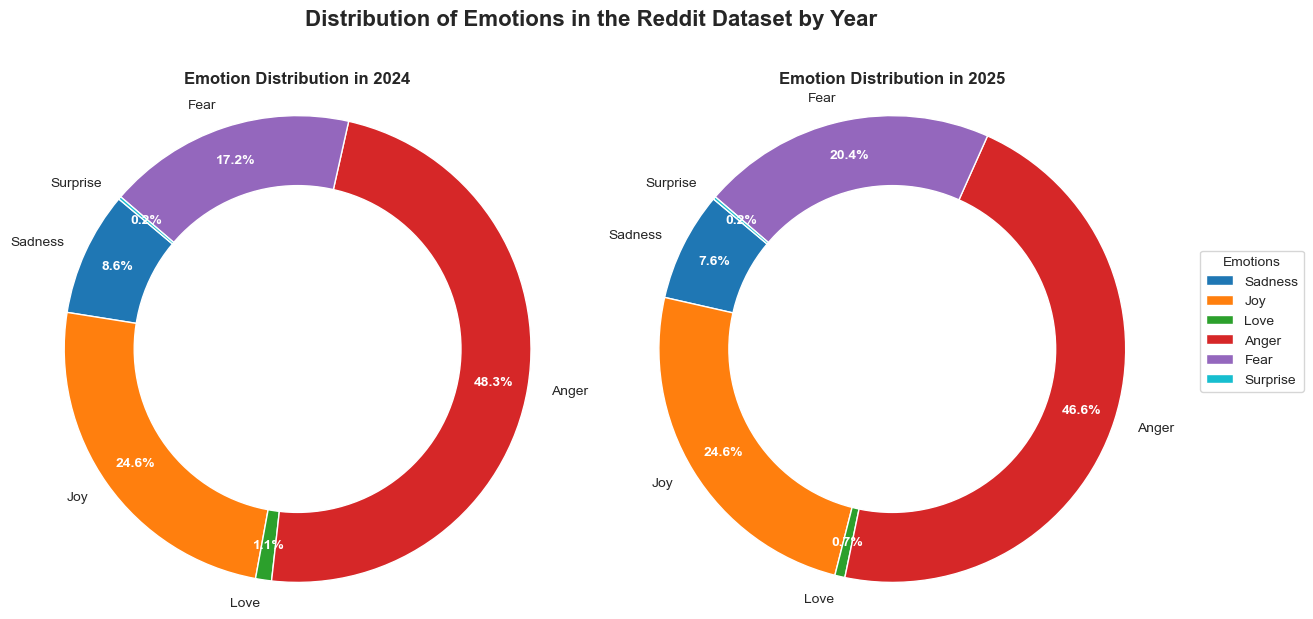

In [34]:
years = redditData['year'].unique()
years.sort()
n_years = len(years)

fig, axes = plt.subplots(1, n_years, figsize=(6 * n_years, 6))

# Iterate through each year and create a pie chart
for i, year in enumerate(years):
    if i >= len(axes):
        break
        
    # Filter data for the current year
    year_data = redditData[redditData['year'] == year]
    label_counts = year_data['labels'].value_counts().sort_index()
    
    labels = [emotion_labels[i] for i in label_counts.index]
    sizes = label_counts.values
    
    wedges, texts, autotexts = axes[i].pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 10},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        pctdistance=0.85
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    axes[i].add_artist(centre_circle)
    axes[i].axis('equal')
    axes[i].set_title(f'Emotion Distribution in {year}', fontsize=12, fontweight='bold')

fig.legend(
    wedges,
    labels,
    title="Emotions",
    loc="center right",
    bbox_to_anchor=(1.1, 0.5)
)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of Emotions in the Reddit Dataset by Year', 
             fontsize=16, 
             fontweight='bold', 
             y=1.02)

plt.tight_layout()
plt.show()

### Analysis of Emotions:

* **Anger**: Being the most prevalent in the both years around 50% this overwhelming amount of anger may be due to different factors such as the ongoing political fragmentation of the spanish people with the rise of the right wing in Europe specially in young men which are usually the demographic who populates online forums like *Reddit*, and this can be a signifacant factor to the porcentage of anger as the current goverment is a socialist one. But anger can be also due to the opposition's action during this last year as the mishandling of PP over a crisis like the DANA floods and their slow disaster response. Its slight decrease in 2025 could suggest a decrease over these factors.

* **Joy**: In second place the consistent proportion of joy may suggest that despite all the negative opinions agains the political landscape in Spain there are always consistent sources of positivity, this could be due to positive economic indicators (like the GDP growth and the decline of unemployment a huge problem that has affected Spain for a long time) as well as , also successful policy implementations, or moments of national unity or achievement. The stability in joy levels indicates these positive aspects persisted across both years.

* **Fear**: The emotion with the biggest shift as it increased a 3.2% between 2024 and 2025, this rise could be linked to the growth of uncertainities all around the world. Potential causes of fear among the spanish people could be the always shifting and evolving geopolitical landscape like the war in Ukraine or Palestine and their wider implications. Another cause could be Trumps new tariffs and his unpredictable ways of leadig the largest economy in the world the United States of America. Fear can be found inside of Spain also due to the housing problem, the rise of prices and the cost of living in general.

* **Sadness**: The presence of sadness, though it decreased slightly in 2025, most likely reflects the impact of challenging events the spanish people have faced during these years. One of these causes could be linked to the devastating DANA floods which unfortunately took the lives of 227 people. The aftermath of these events and the recovery efforts in 2025 could still contribute to sadness, though perhaps with less intensity than in the immediate aftermath. Other societal issues or the perceived negative consequences of political decisions could also contribute to this emotion.

* **Love and Surprise**: The low proportions of these emotions are expected as in a political subreddit as they tend to focus on a critical analysis or debate rather than affectionate expressions.

## **6. Conclusions**

This project aimed to give a understanding of how is the general perception of the spanish people towards the current politcal landscape we have in Spain, of course as we lack of proper equipment and data collection tools this results should not be generalized as everything we have done is based on the subreddit r/SpainPolitics, where even though it is supposed to be an *unbiased* platform for political debate we do not have the means to ensure it.

We used all of the knowledge and techniques that we acquired in the *Applications to Machine Learning* course from the handling of the data to the pipelines of classifiers and NLP techniques used all over the project.

Some of the main problems we faced during the development of this project were the following:

* Englsih/Spanish datasets: as our training dataset only contained text in english and our scrapped dataset was mainly in spanish, and translating was a big deal for us, we did not want to loose the context of the texts in spanish as it could lead to a poor performance in the labeling of the data. We took into consideration different alternatives but ended up choosing a pretrained transformer that was ran locally.
* Handling the representations as our datasets were so big our machines could not always support that many data at the same time so we had to remove them and load them when necessary
* Overall technical limitations: As we wanted to make a project that could display the use of current SOTA technologies like attention mechanisms and transformers most of the heavy work was made in 2 machines with 16 Gb of RAM both and GPUS: RTX 3060 and RTX 4060 which lacked the power to handle a bigger dataset for training our models and translating the a much bigger dataset in spanish.

Even though we faced all these problems and limitations we believe this project can showcase how important NLP and ML can be to understanding the world we live in.\
We hope you enjoyed our project as much as we enjoyed developing it.